# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы. 

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
# !pip install datasets

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import re

import seaborn
seaborn.set(palette='summer')

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [4]:
# Загрузим датасет
dataset = load_dataset('imdb', cache_dir="/datasets/imdb")

Found cached dataset imdb (D:/datasets/imdb/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

#### Разделить отдельные тренировочные примеры на отдельные предложения

In [5]:
# В датасете 25к обучающей 25к тестовой и 50к не размеченной, для нашей задачи можно использовать все три
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

###### Необходимо произвести предварительный анализ текста, понять что учитывать, а что исключить из текста

In [6]:
# Смотрим что вообще внутри обучающей выборки и как текст бьется на предложения
first_item = next(iter(dataset["train"]))
sents_item = nltk.sent_tokenize(first_item["text"])
len(sents_item), sents_item[1]

(9,
 'I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life.')

In [7]:
# В тексте есть тэги (<br />) из-за которых некоторые предложения не разбиваются и остаются склееными.
# Попробуем узнать какие еще тэги есть в обучающей выборке и сколько их
uniq_tags = set([])
count_tags = []
for item in tqdm(dataset["train"]):
    text = item["text"]
    tags = re.findall(r"(<[^>]+?>)", text)
    uniq_tags = uniq_tags.union(tags)
    count_tags.append(len(tags))
print(f"Уникальные тэги встречаемые в тексте: {uniq_tags}")
print(f"Всего тэгов в выборке: {sum(count_tags)}")
print(f"Среднее кол-во тэгов в одном тексте: {sum(count_tags)/len(count_tags)}")

  0%|          | 0/25000 [00:00<?, ?it/s]

Уникальные тэги встречаемые в тексте: {'<br />', '< than 30 minutes of watching, being bored and irritated. <br />', "< $600 per screen its opening weekend, and just over $400 each, after its month's theater run in latter 2002. Overall gross was $261K, which I'd doubt could cover cast and crew's hotel and food for a week on location.<br />", '< and make notes for my partial "review" to show how foolish the movie is. "Resident Evil" (horror) or "Dude, Where\'s My Car?" (comedy) I can watch over and over again and still enjoy! But this...!<br />', '<SPOILER>', '<sp?) classic "Romeo & Juliet". Guess I\'ll have to rent that next.<br />', '<em>', '<=8.<br />', '</em>', '<<<sigh>', '< who was to be a victim, but woman-power trumps evil scientist every time.<br />', '</i>', '</SPOILER>', '<grin>', '<http://rogerebert.suntimes.com/apps/pbcs.dll/section?category=ANSWERMAN>', '<3 <br />', '<hr>', '<i>'}
Всего тэгов в выборке: 101892
Среднее кол-во тэгов в одном тексте: 4.07568


In [4]:
# иногда разметка в текстах не точная и также треугольные скобки моут использоваться не только для тэгов, поэтому
# в найденные тэги попадают куски текста, но их очень мало, поэтому их проще исключить из обучающей выборки. 
# В среднем 4 тэга на текст, это значит что в среднем идет склейка 4 пар предложений, тогда как их надо делить 
# При исключения всех тэгов при подготовке датасета также исключим и одиночные треугольные скобки
def remove_tags(text):
    text = text.replace('\n', ' ')
    # Удаляем тэги
    text = re.sub(r"(<[^>]+?>)", ". ", text)
    # Заменяем многоточние на 1 точку
    text = re.sub(r'\.+', '. ', text)
    # Заменяем ! и ? на точку
    text = re.sub(r'[\?\!]', '. ', text)
    # Удаляем одиночные треугольные тэги
    text = re.sub(r"[><]", " ", text)
    return text

In [9]:
# Проверяем
first_item = next(iter(dataset["train"]))
sents_item = nltk.sent_tokenize(remove_tags(first_item["text"]))
len(sents_item), sents_item[1]
# отлично вместо 9 предложений стало 12

(15,
 'I also heard that at first it was seized by U. S.  customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.')

In [10]:
text = "I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967."
text = "ответствует словесным символам Unicode; сюда входят буквенно-цифровые символы (как определено str.isalnum()), а также символ подчеркивания ( _). Если ASCIIфлаг используется, то только [a-zA-Z0-9_]соответствует."
words = re.findall(r"([a-zA-Zа-яА-Я]+)", text)
# words = re.findall(r"(\w+)", text)
print(words)

['ответствует', 'словесным', 'символам', 'Unicode', 'сюда', 'входят', 'буквенно', 'цифровые', 'символы', 'как', 'определено', 'str', 'isalnum', 'а', 'также', 'символ', 'подчеркивания', 'Если', 'ASCIIфлаг', 'используется', 'то', 'только', 'a', 'zA', 'Z', 'соответствует']


#### Подзадачи:
1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов. 

In [11]:
text = "Mad Magazine may have? a lot of! crazy people working for it...but obviously someone there had some common sense when the powers-that-be disowned this waste of celluloid...the editing is el crapo, the plot is incredibly thin and stupid...and the only reason it gets a two out of ten is that Stacy Nelkin takes off some of her clothes and we get a nice chest shot...I never thought I would feel sorry for Ralph Macchio making the decision to be in this thing, but I do...and I REALLY feel bad for Ron Leibman and Tom Poston, gifted actors who never should have shown up in this piece of...film...at least Mr. Leibman had the cajones to refuse to have his name put anywhere on the movie...and he comes out ahead...there are actually copies of this thing with Mad's beginning sequence still on it...if you can locate one, grab it cuz it is probably worth something...it's the only thing about this movie that's worth anything...and a note to the folks at IMDb.com...there is no way to spoil this movie for anyone...the makers spoiled it by themselves..."
text = re.sub(r'\.+', '. ', text)
text = re.sub(r'[\?\!]', '. ', text)
text

"Mad Magazine may have.  a lot of.  crazy people working for it. but obviously someone there had some common sense when the powers-that-be disowned this waste of celluloid. the editing is el crapo, the plot is incredibly thin and stupid. and the only reason it gets a two out of ten is that Stacy Nelkin takes off some of her clothes and we get a nice chest shot. I never thought I would feel sorry for Ralph Macchio making the decision to be in this thing, but I do. and I REALLY feel bad for Ron Leibman and Tom Poston, gifted actors who never should have shown up in this piece of. film. at least Mr.  Leibman had the cajones to refuse to have his name put anywhere on the movie. and he comes out ahead. there are actually copies of this thing with Mad's beginning sequence still on it. if you can locate one, grab it cuz it is probably worth something. it's the only thing about this movie that's worth anything. and a note to the folks at IMDb. com. there is no way to spoil this movie for anyon

In [5]:
# Чистим текст от всего кроме алфавитных символов
def clear_text(text):
    text = text.replace('\n', ' ')
    # Выделяем только слова без цифр и спецсимволов
    words = re.findall(r"\b([a-zA-Zа-яА-Я]+)\b", text)
    return words


In [13]:
# Для выбора огранчиений по размеру для предложений надо посмотреть всю выборку
lens_sentences = []
for item in tqdm(dataset["train"]):
    text_item = item["text"]
    text_item = remove_tags(text_item)
    text_sents = nltk.sent_tokenize(text_item)
    for sent in text_sents:
        words_sent = clear_text(sent.lower())
        # Предложения меньше 4 и больше 60 слов считаем по умолчанию выбросами
        if 3 < len(words_sent) < 60:
            lens_sentences.append(len(words_sent))    

  0%|          | 0/25000 [00:00<?, ?it/s]

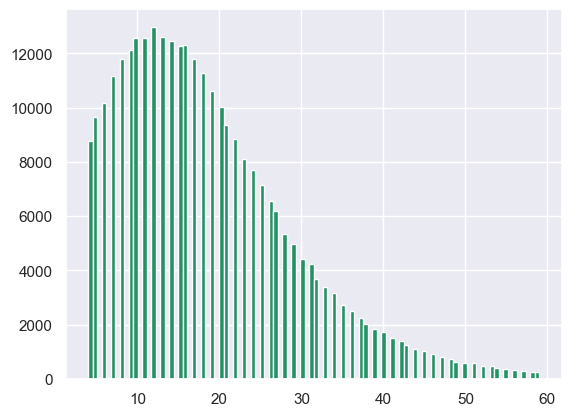

In [14]:
# Смотрим распределение размера предложений
# Расределение размеров текстов
plt.hist(lens_sentences, bins=100)
plt.show() 

In [259]:
# Исходя из распределения выбираем допустимые размеры предложений
max_word_threshold = 25 # Максимальный размер предложений
min_word_threshold = 4 # Минимальный размер предложений
words = Counter()
sentences = []
lens_sentences = []
for item in tqdm(dataset["train"]):
    text_item = item["text"]
    text_item = remove_tags(text_item)
    text_sents = nltk.sent_tokenize(text_item)
    for sent in text_sents:
        words_sent = clear_text(sent.lower())
        if min_word_threshold <= len(words_sent) <= max_word_threshold:
            # words считает кол-во встречаемости слов
            words.update(words_sent) 
            sentences.append(words_sent)
            lens_sentences.append(len(words_sent))
    
print("- Всего предложений:", len(sentences))
print("- Средняя длина предложения:", sum(lens_sentences)/len(lens_sentences))
print("- Пример предложения:", sentences[0])
print("- Всего уникальных слов:", len(words.keys()))
print("- Топ 5 популярных слов:", words.most_common(5))

  0%|          | 0/25000 [00:00<?, ?it/s]

- Всего предложений: 236361
- Средняя длина предложения: 14.014989782578343
- Пример предложения: ['i', 'rented', 'i', 'am', 'curious', 'yellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in']
- Всего уникальных слов: 56208
- Топ 5 популярных слов: [('the', 182695), ('a', 89492), ('and', 86029), ('of', 74676), ('to', 71218)]


Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [260]:
# Наполнение словаря
vocab_size = 30000
vocab = set([w[0] for w in words.most_common(vocab_size)])
vocab.update(set(['<unk>', '<bos>', '<eos>', '<pad>']))

In [261]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [262]:
# обновляем размер словаря
vocab_size = len(vocab)
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 30004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [263]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [6]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']        

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(w, self.unk_id) for w in self.data[idx]] 
        tokenized_sentence += [self.eos_id]
        
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [18]:
def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)
    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [266]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [71]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            predict = model(batch["input_ids"].to(device))# Посчитайте логиты предсказаний следующих слов
            flatten_predict = predict.flatten(start_dim=0, end_dim=1)
            loss = criterion(flatten_predict, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())
    
    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [24]:
def train_model(model, optim, criterion, epochs = 10):
    # Напишите код здесь
    losses = []
    perplexites = []
    for epoch in tqdm(range(epochs)):
        model.train()
        print(epoch)
        epoch_losses = []
        epoch_perplexites = []
        
        for batch in tqdm(train_dataloader):
            optim.zero_grad()
            x_train = batch["input_ids"]
            x_train.to(device)
            y_train = batch["target_ids"]
            predict = model(x_train)
            flatten_predict = predict.flatten(start_dim=0, end_dim=1) # Приводим логит к виду [batch_size, vocab_size]
            loss = criterion(flatten_predict, y_train.flatten()) # Сравниваем распределение [batch_size, vocab_size] с верным классом [batch_size]
            loss.backward()
            optim.step()
            epoch_losses.append(loss.detach().cpu())
        
        model.eval()
        perplexity = evaluate(model, criterion, eval_dataloader)
        perplexites.append(perplexity)
        losses.append(sum(epoch_losses)/len(epoch_losses))
        
    return losses, perplexites


In [122]:
def print_score(losses, perplexites, fix_epoches=-1):
    if fix_epoches == -1:
        fix_epoches = len(losses)
    print(f"Для {fix_epoches} эпох:")
    print(f"- Наименьший loss: {min(losses[:fix_epoches])}")
    print(f"- Наименьшая перплексия: {min(perplexites[:fix_epoches])}")

In [43]:

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().detach().cpu())
            max_grads.append(p.grad.abs().max().detach().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(ave_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, -0.5, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=-0.5, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

def plot_weight_flow(named_parameters):
    ave_weights = []
    max_weights = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_weights.append(p.abs().mean().detach().cpu())
            max_weights.append(p.abs().max().detach().cpu())
    plt.bar(np.arange(len(max_weights)), max_weights, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(ave_weights)), ave_weights, alpha=0.1, lw=1, color="b")
    plt.hlines(0, -0.5, len(ave_weights)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_weights), 1), layers, rotation="vertical")
    plt.xlim(left=-0.5, right=len(ave_weights))
    plt.xlabel("Layers")
    plt.ylabel("average weights")
    plt.title("Weights flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-weights', 'mean-weights', 'zero-weights'])   

### Базовая модель (baseline)
20 эпох  
Наименьший loss: 4.694701671600342  
Наименьшая перплексия: 104.05185881115142  

In [279]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size,  batch_first=True)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        output, _ = self.rnn(x)
        output = self.tanh(self.fc(output))
        output = self.dropout(output)
        output = self.predict(output)
        return output

In [280]:
model = LanguageModel(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [90]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

3


  0%|          | 0/1478 [00:00<?, ?it/s]

4


  0%|          | 0/1478 [00:00<?, ?it/s]

5


  0%|          | 0/1478 [00:00<?, ?it/s]

6


  0%|          | 0/1478 [00:00<?, ?it/s]

7


  0%|          | 0/1478 [00:00<?, ?it/s]

8


  0%|          | 0/1478 [00:00<?, ?it/s]

9


  0%|          | 0/1478 [00:00<?, ?it/s]

10


  0%|          | 0/1478 [00:00<?, ?it/s]

11


  0%|          | 0/1478 [00:00<?, ?it/s]

12


  0%|          | 0/1478 [00:00<?, ?it/s]

13


  0%|          | 0/1478 [00:00<?, ?it/s]

14


  0%|          | 0/1478 [00:00<?, ?it/s]

15


  0%|          | 0/1478 [00:00<?, ?it/s]

16


  0%|          | 0/1478 [00:00<?, ?it/s]

17


  0%|          | 0/1478 [00:00<?, ?it/s]

18


  0%|          | 0/1478 [00:00<?, ?it/s]

19


  0%|          | 0/1478 [00:00<?, ?it/s]

Wall time: 1h 10min 52s


Наименьший loss: 4.694701671600342


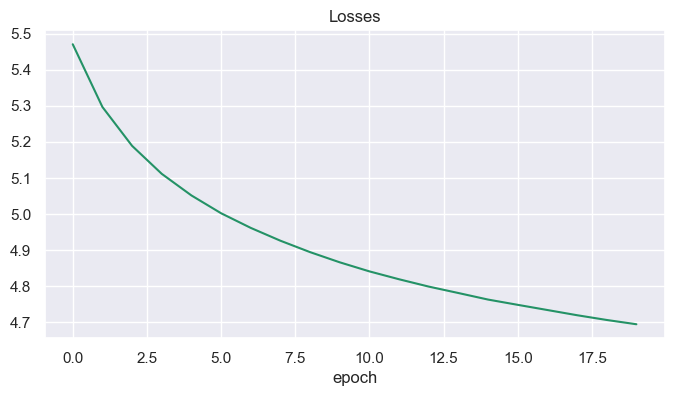

In [109]:
print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

Наименьшая перплексия: 104.05185881115142


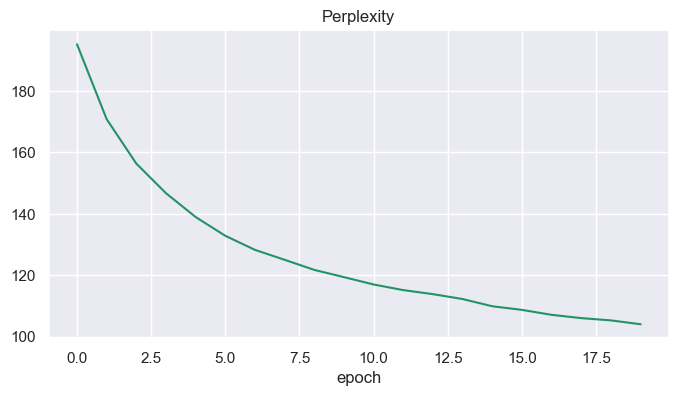

In [110]:
print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [104]:
print_score(losses, perplexites)

Для 20 эпох:
- Наименьший loss: 4.694701671600342
- Наименьшая перплексия: 104.05185881115142


In [105]:
print_score(losses, perplexites, fix_epoches=7)

Для 7 эпох:
- Наименьший loss: 4.961692810058594
- Наименьшая перплексия: 128.27027759304295


##### Предварительный итог: Базовая модель (baseline)
Для 20 эпох:
- Наименьший loss: 4.694701671600342  
- Наименьшая перплексия: 104.05185881115142  

По графикам лосса и перплексии видно, что чем больше эпох, тем ниже (лучше) эти показатели.
Однако 20 эпох довольно долго считаются, поэтому все эксперименты будем проводить на более меньшем кол-ве эпох, например 7, а уже для конечной модели увеличим число эпох.  
Для 7 эпох у базовой модели показатели:
- Наименьший loss: 4.961692810058594
- Наименьшая перплексия: 128.27027759304295


### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

Попробуем различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers.

In [31]:
epochs = 7

##### Модель на GRU вместо RNN

In [112]:
class LanguageModel_v2_GRU(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        output, _ = self.gru(x)
        output = self.tanh(self.fc(output))
        output = self.dropout(output)
        output = self.predict(output)
        return output

In [113]:
model = LanguageModel_v2_GRU(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [114]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=epochs)

  0%|          | 0/7 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

3


  0%|          | 0/1478 [00:00<?, ?it/s]

4


  0%|          | 0/1478 [00:00<?, ?it/s]

5


  0%|          | 0/1478 [00:00<?, ?it/s]

6


  0%|          | 0/1478 [00:00<?, ?it/s]

Wall time: 26min 46s


Наименьший loss: 4.943782806396484


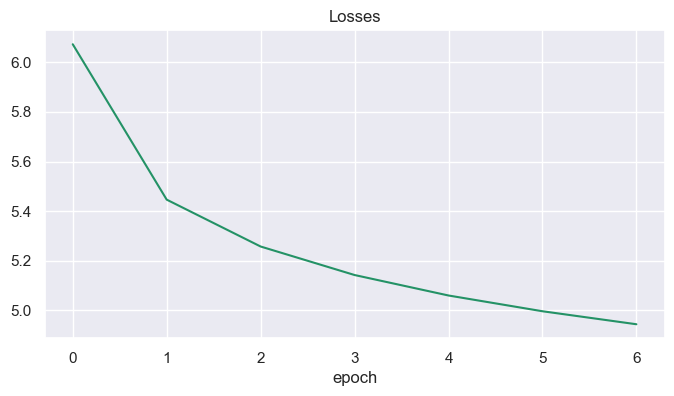

In [116]:
print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

Наименьшая перплексия: 125.11486988150196


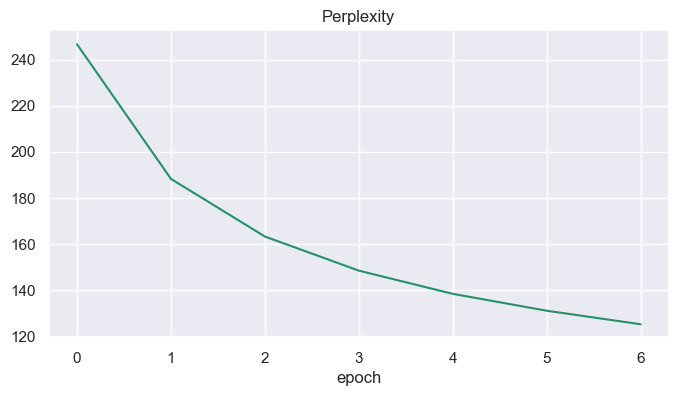

In [117]:
print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [119]:
print(f"Базовая модель c GRU вместо RNN.")
print_score(losses, perplexites)

Базовая модель c GRU вместо RNN.
Для 7 эпох:
- Наименьший loss: 4.943782806396484
- Наименьшая перплексия: 125.11486988150196


In [123]:
class LanguageModel_v3_LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(self.fc(output))
        output = self.dropout(output)
        output = self.predict(output)
        return output

In [124]:
model = LanguageModel_v3_LSTM(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [125]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=epochs)

  0%|          | 0/7 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

3


  0%|          | 0/1478 [00:00<?, ?it/s]

4


  0%|          | 0/1478 [00:00<?, ?it/s]

5


  0%|          | 0/1478 [00:00<?, ?it/s]

6


  0%|          | 0/1478 [00:00<?, ?it/s]

Wall time: 34min 27s


Наименьший loss: 4.939565181732178


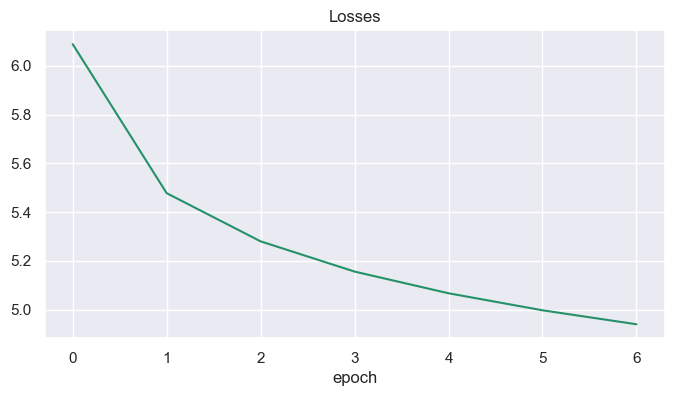

In [126]:
print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

Наименьшая перплексия: 124.8495824491823


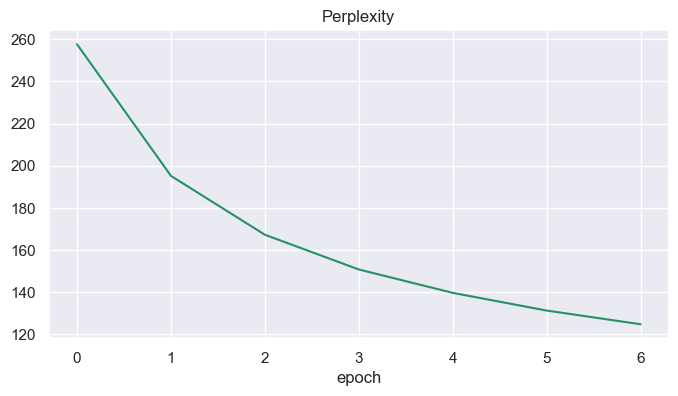

In [127]:
print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [128]:
print(f"Базовая модель c LSTM вместо RNN.")
print_score(losses, perplexites)

Базовая модель c LSTM вместо RNN.
Для 7 эпох:
- Наименьший loss: 4.939565181732178
- Наименьшая перплексия: 124.8495824491823


##### Предварительный итог: Выбор рекурентной модели 
Сравнение для 7 эпох, базовые настройки (1 слой, однонаправленный):  
* Обычный RNN  :
    - Наименьший loss: 4.961692810058594  
    - Наименьшая перплексия: 128.27027759304295  
    - 1 эпоха считается ~ 2:48
* GRU:  
    - Наименьший loss: 4.943782806396484  
    - Наименьшая перплексия: 125.11486988150196  
    - 1 эпоха считается ~ 3:06
* LSTM:  
    - Наименьший loss: 4.939565181732178
    - Наименьшая перплексия: 124.8495824491823    
    - 1 эпоха считается ~ 4:01

Различия LSTM и GRU в скорости работы и в точности показывают, что LSTM совсем немного точнее, чем GRU, но при этом дольше 1 эпоха 4 минуты вместо 3.



In [130]:
class LanguageModel_v4_LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=2, bias=True)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(self.fc(output))
        output = self.dropout(output)
        output = self.predict(output)
        return output

model = LanguageModel_v4_LSTM(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [131]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=epochs)

  0%|          | 0/7 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

3


  0%|          | 0/1478 [00:00<?, ?it/s]

4


  0%|          | 0/1478 [00:00<?, ?it/s]

5


  0%|          | 0/1478 [00:00<?, ?it/s]

6


  0%|          | 0/1478 [00:00<?, ?it/s]

Wall time: 23min 21s


Наименьший loss: 5.045697212219238


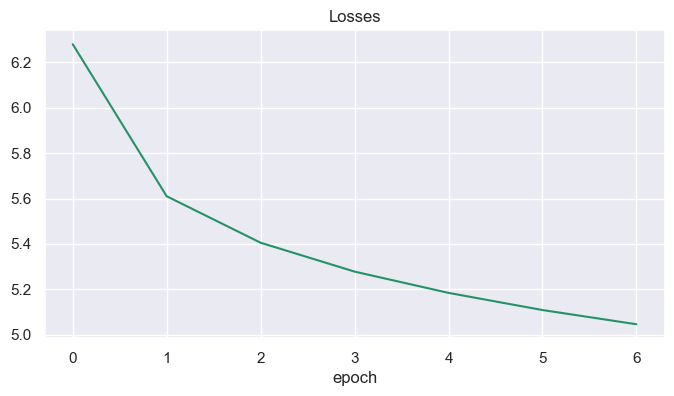

In [132]:
print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

Наименьшая перплексия: 139.97499896953633


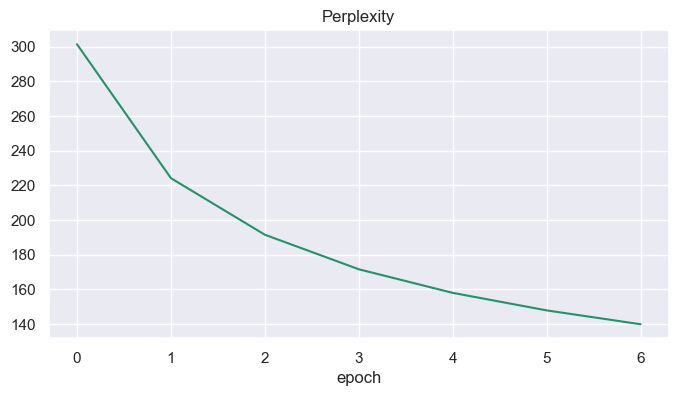

In [133]:
print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [134]:
print(f"LSTM c двумя слоями")
print_score(losses, perplexites)

LSTM c двумя слоями
Для 7 эпох:
- Наименьший loss: 5.045697212219238
- Наименьшая перплексия: 139.97499896953633


In [61]:
class LanguageModel_v5_LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=2, bias=True)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(self.fc(output))
        output = self.dropout(output)
        output = self.predict(output)
        return output

model = LanguageModel_v5_LSTM(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Wall time: 12min 54s


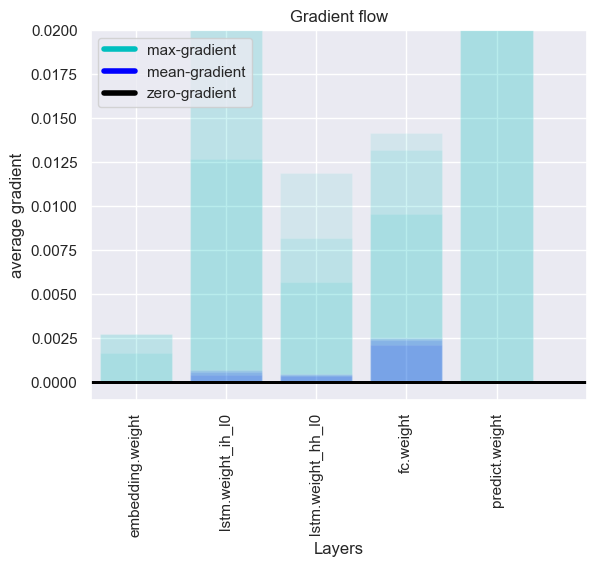

In [62]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

# LSTM 1 слой (3 эпохи)

Наименьший loss: 5.269344329833984
Наименьшая перплексия: 166.8293450590852


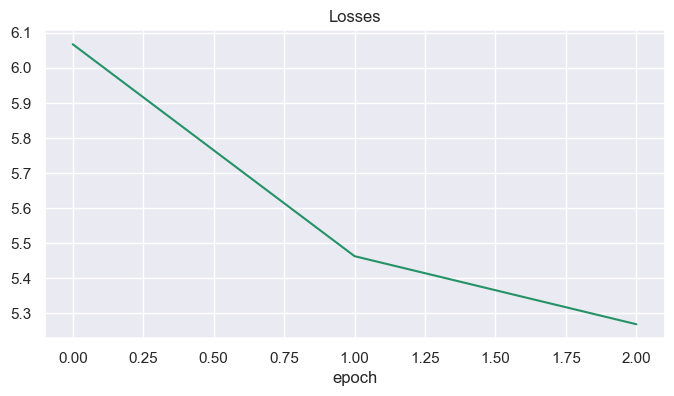

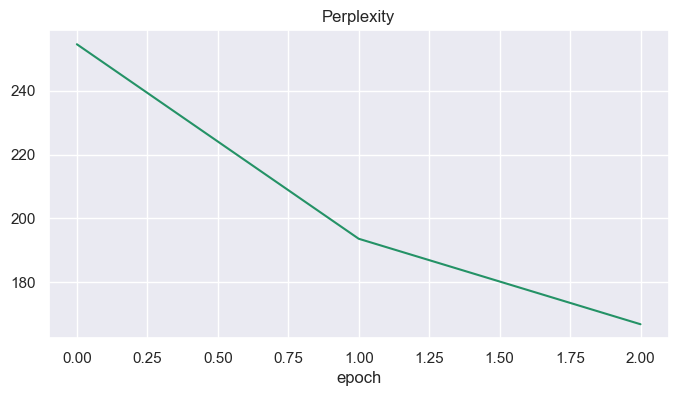

In [56]:
print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [57]:
print(f"LSTM c 1 слоями")
print_score(losses, perplexites,3 )

LSTM c 1 слоями
Для 3 эпох:
- Наименьший loss: 5.269344329833984
- Наименьшая перплексия: 166.8293450590852


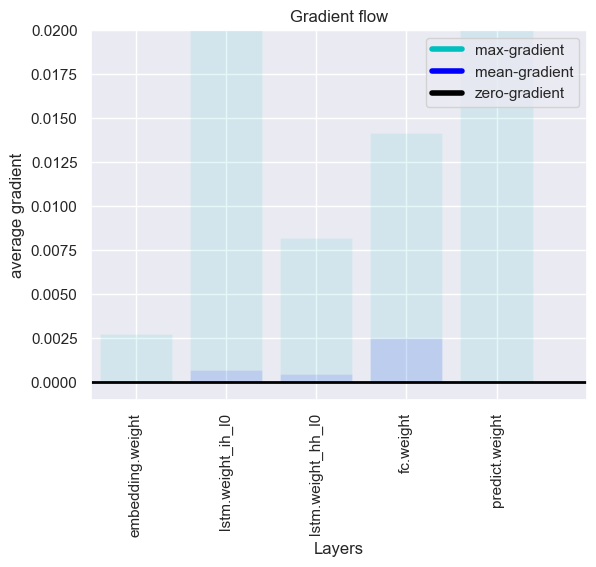

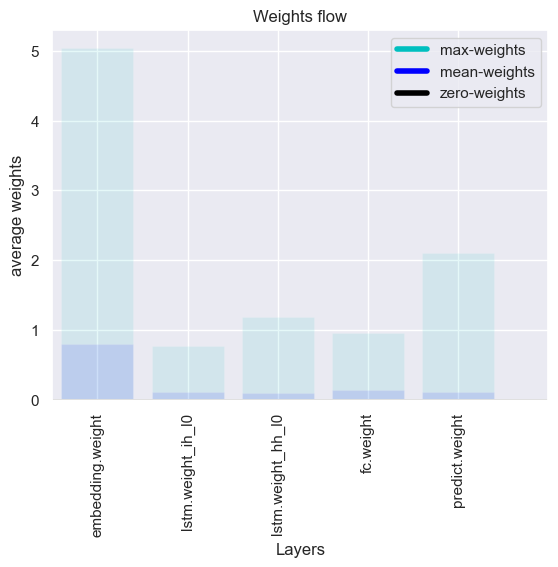

In [66]:
# Рапределение градиентов: 3 эпохи 1 слоя LSTM
plot_grad_flow(model.named_parameters())
plt.show()
# Рапределение весов: 3 эпохи 1 слоя LSTM
plot_weight_flow(model.named_parameters())

# LSTM 2 слоя (3 эпохи)

Наименьший loss: 5.411147594451904
Наименьшая перплексия: 193.9280113616547


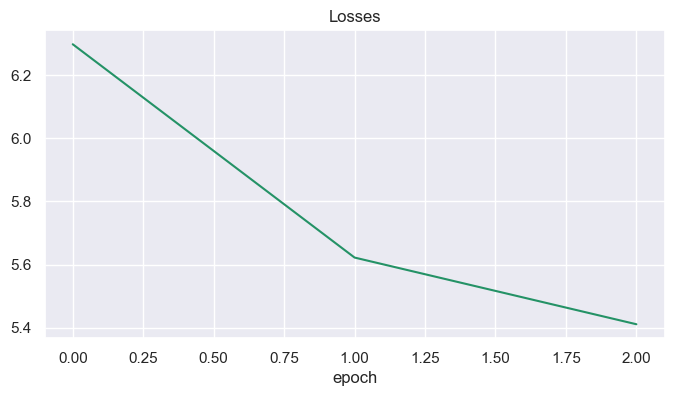

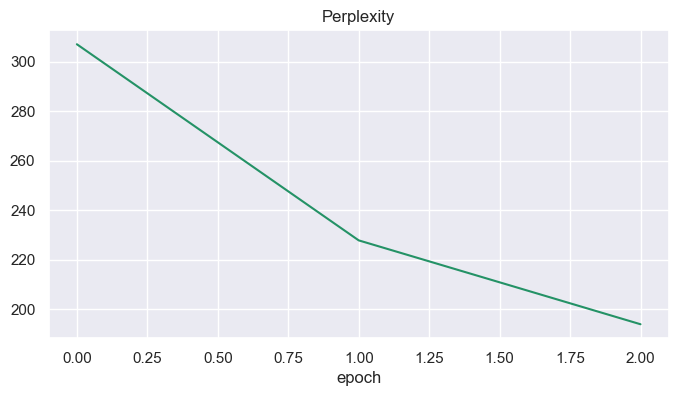

In [49]:
print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [50]:
print(f"LSTM c двумя слоями")
print_score(losses, perplexites,3 )

LSTM c двумя слоями
Для 3 эпох:
- Наименьший loss: 5.411147594451904
- Наименьшая перплексия: 193.9280113616547


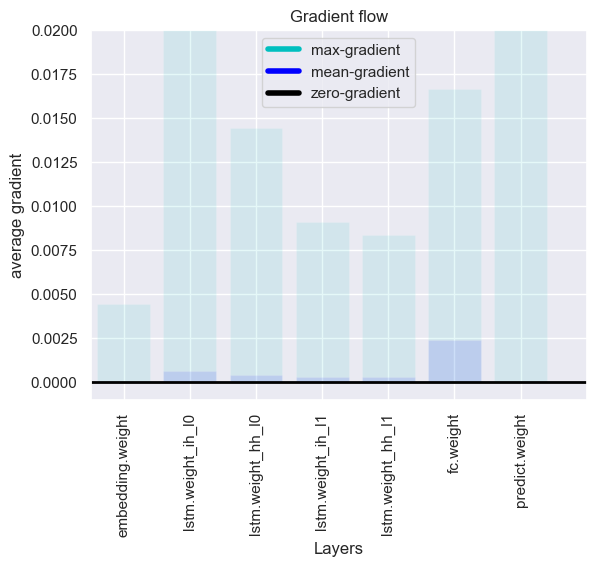

In [52]:
# Рапределение градиентов: 3 эпохи 2 слоя LSTM
plot_grad_flow(model.named_parameters())

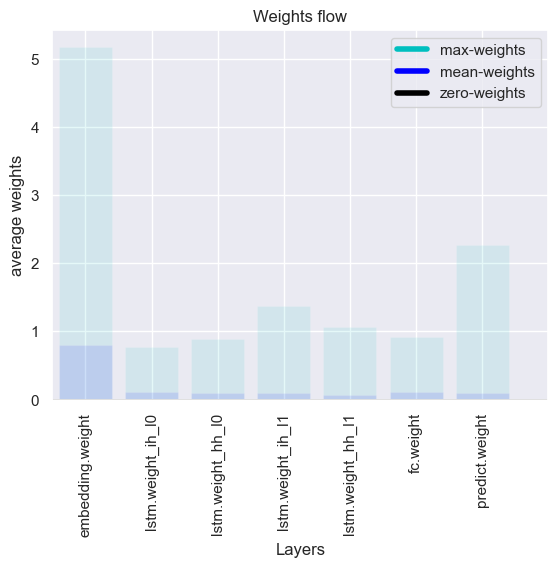

In [53]:
# Рапределение весов: 3 эпохи 2 слоя LSTM
plot_weight_flow(model.named_parameters())

# LSTM 4 слоя (3 эпохи)

Наименьший loss: 5.6512837409973145


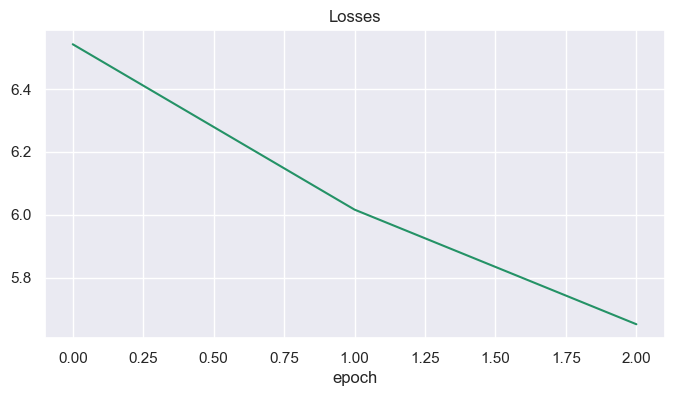

In [37]:
print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

Наименьшая перплексия: 245.6312970413274


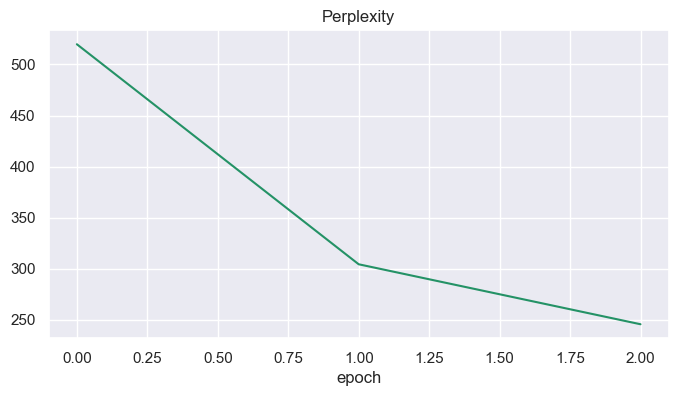

In [38]:
print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [42]:
print(f"LSTM c четырьмя слоями")
print_score(losses, perplexites,3 )

LSTM c четырьмя слоями
Для 3 эпох:
- Наименьший loss: 5.6512837409973145
- Наименьшая перплексия: 245.6312970413274


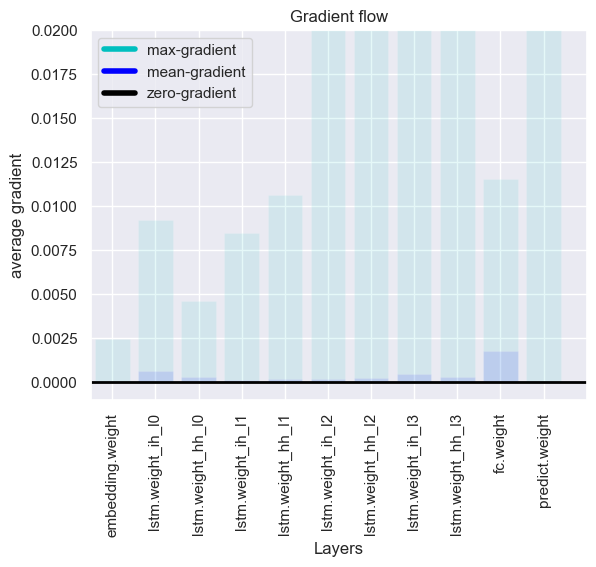

In [44]:
# Рапределение градиентов: 3 эпохи 4 слоя LSTM
plot_grad_flow(model.named_parameters())

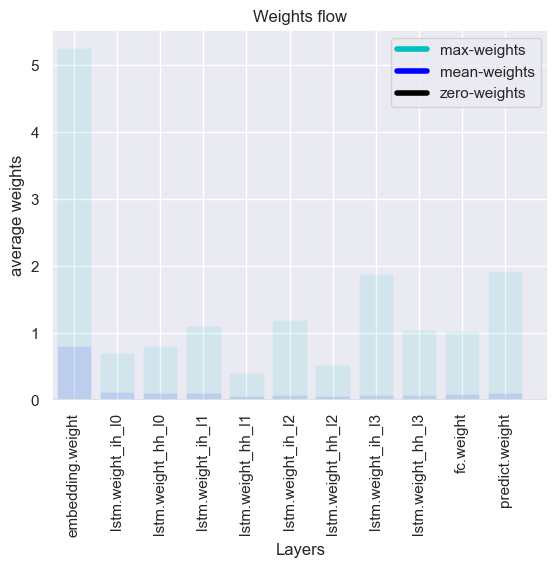

In [46]:
# Рапределение весов: 3 эпохи 2 слоя LSTM
plot_weight_flow(model.named_parameters())

##### Предварительный итог: Выбор кол-ва слоев
Сравнение для 7 эпох, LSTM (произведена небольшая оптимизация и время рассчета для LSTM снизилось с 4 до 2 минут)
* LSTM 1 внутренний слой:  
    - Наименьший loss: 4.939565181732178
    - Наименьшая перплексия: 124.8495824491823    
    - 1 эпоха считается ~ 2:31 (произведена небольшая оптимизация и время рассчета для LSTM снизилось с 4 до 2 минут)
* LSTM 2 внутренних слоя:  
    - Наименьший loss: 5.045697212219238
    - Наименьшая перплексия: 139.97499896953633    
    - 1 эпоха считается ~ 2:32
* LSTM 4 внутренних слоя:  
    - Наименьший loss: 5.150515079498291
    - Наименьшая перплексия: 157.9109002811052
    - 1 эпоха считается ~ 2:53-3:36


При повышении слоев ухудшились лосс и перплексия. Скорее всего это связано с затуханием градиента.  
#### Проверяем затухание градиента

##### Рапределение градиентов для модели с 1 слоем LSTM (3 эпохи)
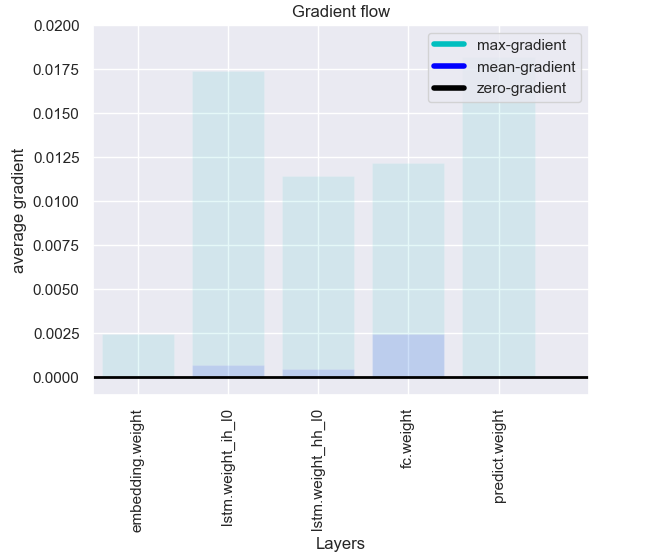

##### Рапределение градиентов для модели с 4 слоями LSTM (3 эпохи)
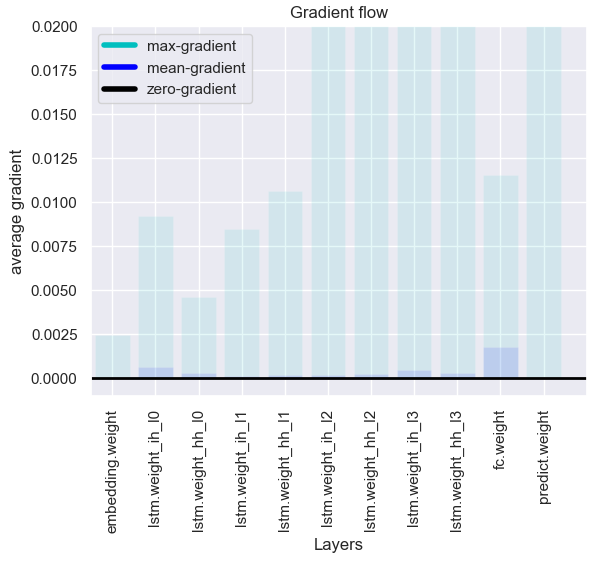


Заметно, что при 4х внутренних слоях LSTM внутриние слои среднее значание градиента очень мало, т.е. градиент внутринние слои LSTM в данной конфигурации плохо обучаются, необходмио изменить модель либо изменить данные (длина предложений или размер словаря).



### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

- Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
- Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
- Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие

#### 6 модель: LSTM (1 слой), убрана активация после lstm

In [116]:
torch.manual_seed(53)
np.random.seed(53)

class LanguageModel_v6_LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1)
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        # output = self.tanh(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.tanh(output)
        # output = self.tanh(self.fc(output))
        # output = self.dropout(output)
        output = self.predict(output)
        return output

model = LanguageModel_v6_LSTM(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [117]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Wall time: 11min 59s


Наименьший loss: 5.311896800994873
Наименьшая перплексия: 187.64482795418084


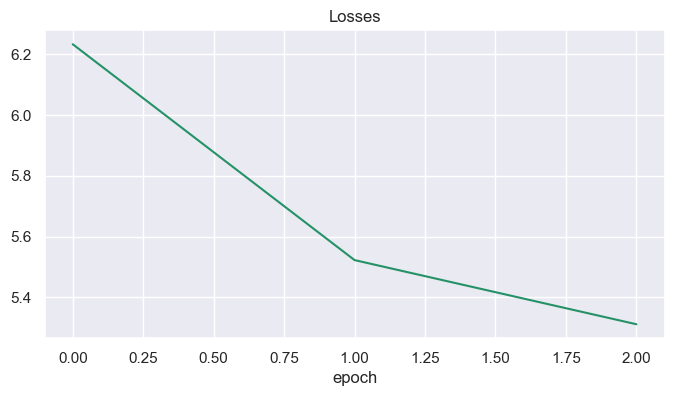

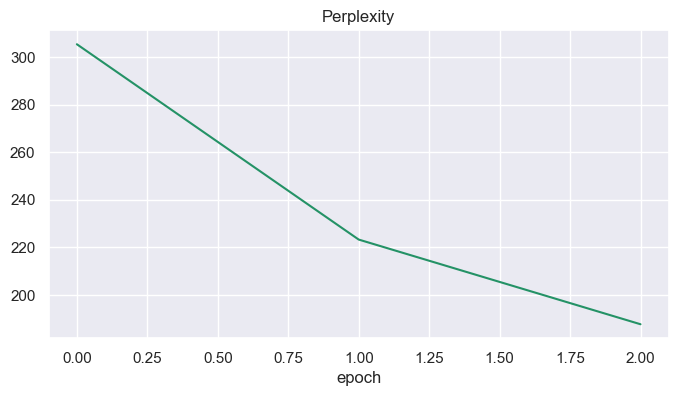

Для 3 эпох:
- Наименьший loss: 5.311896800994873
- Наименьшая перплексия: 187.64482795418084


In [118]:
print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 7 модель: LSTM (1 слой) + BiDirect

In [125]:
class LanguageModel_v7_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.tanh(output)
        output = self.predict(output)
        return output

model = LanguageModel_v7_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [126]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Wall time: 7min 49s


Наименьший loss: 0.5849314332008362
Наименьшая перплексия: 1.4564730882386625


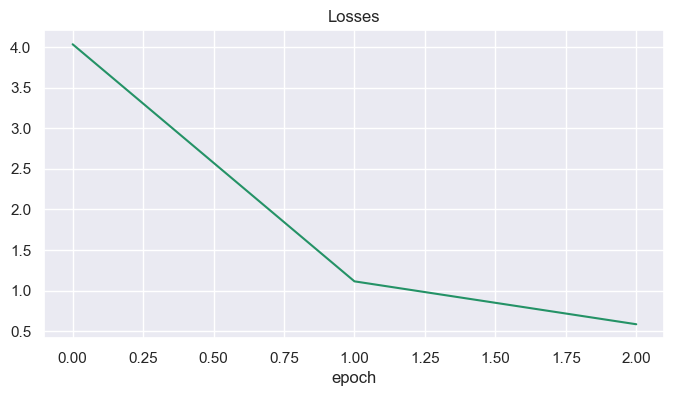

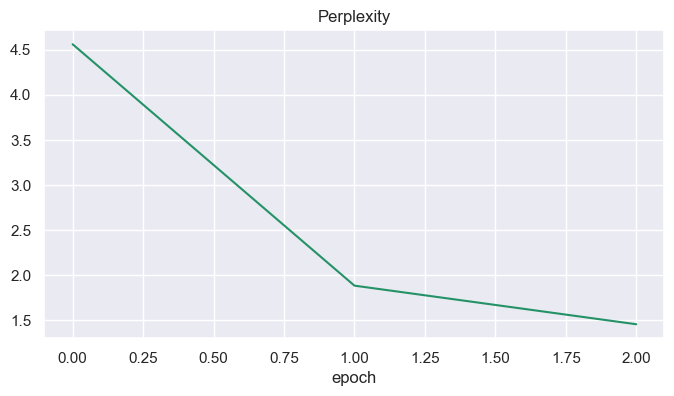

Для 3 эпох:
- Наименьший loss: 0.5849314332008362
- Наименьшая перплексия: 1.4564730882386625


In [127]:
print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 8 модель: LSTM (2 слой) + BiDirect

In [129]:
class LanguageModel_v8_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.tanh(output)
        output = self.predict(output)
        return output

model = LanguageModel_v8_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 1.4935046434402466
Наименьшая перплексия: 2.871180099068266


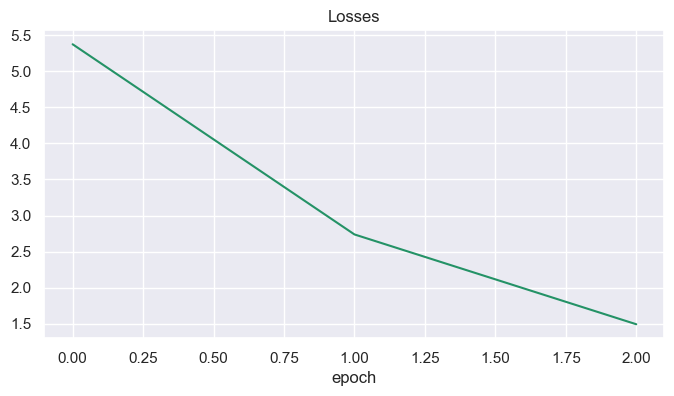

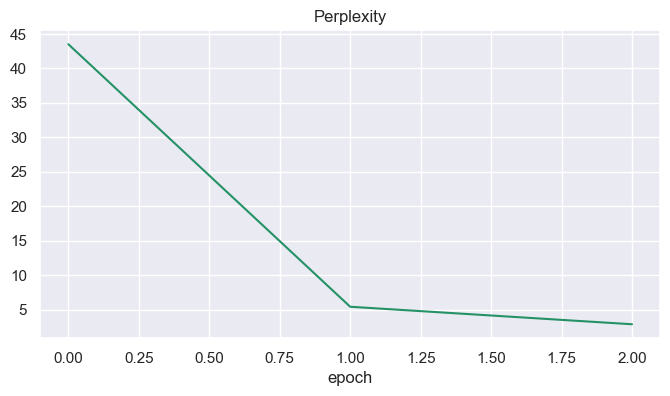

Для 3 эпох:
- Наименьший loss: 1.4935046434402466
- Наименьшая перплексия: 2.871180099068266
Wall time: 8min 20s


In [130]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### Различные размеры скрытого состояния. 

#### 9 модель: LSTM (1 слой) + BiDirect + hidden_size=256

In [159]:
class LanguageModel_v9_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=256):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.tanh(output)
        output = self.predict(output)
        return output

model = LanguageModel_v9_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.09795942157506943
Наименьшая перплексия: 1.038092632185329


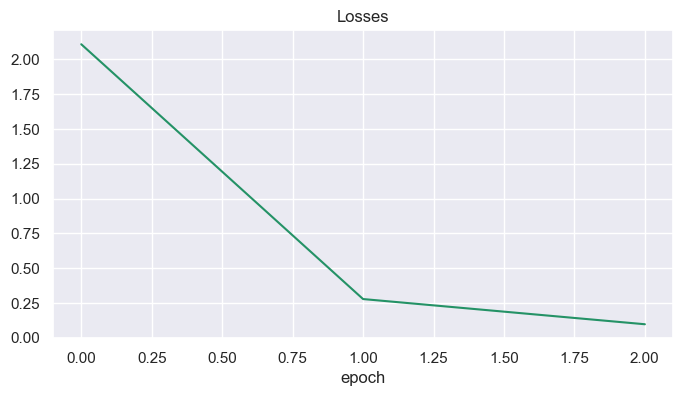

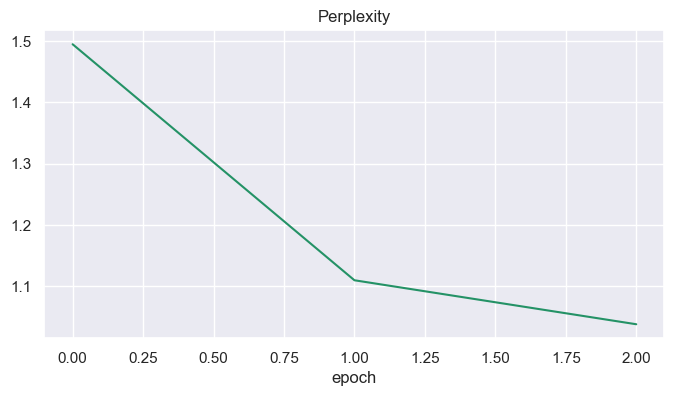

Для 3 эпох:
- Наименьший loss: 0.09795942157506943
- Наименьшая перплексия: 1.038092632185329
Wall time: 11min 2s


In [134]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 10 модель: LSTM (1 слой) + BiDirect + hidden_size=256 + 2 слоя

In [131]:
class LanguageModel_v10_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=256):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.tanh(output)
        output = self.predict(output)
        return output

model = LanguageModel_v10_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:02<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.513067364692688
Наименьшая перплексия: 1.4310750351065682


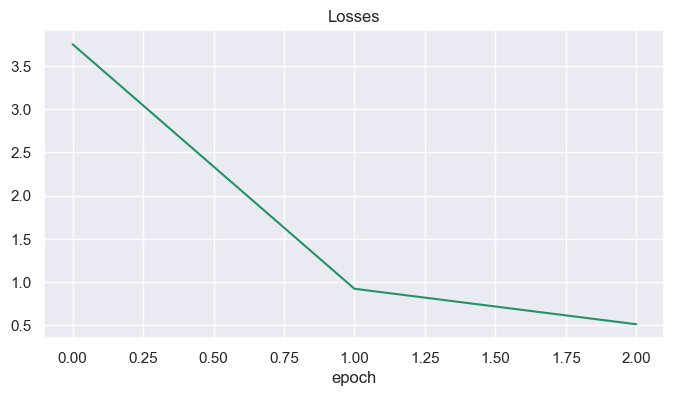

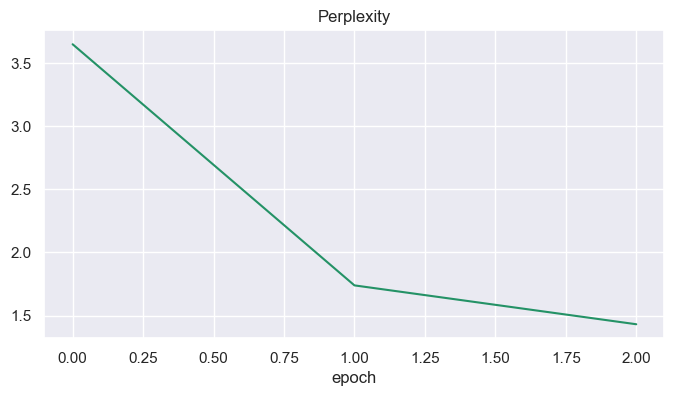

Для 3 эпох:
- Наименьший loss: 0.513067364692688
- Наименьшая перплексия: 1.4310750351065682
Wall time: 12min 53s


In [132]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 11 модель: LSTM (1 слой) + BiDirect + hidden_size=512

In [135]:
class LanguageModel_v11_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=512):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.tanh(output)
        output = self.predict(output)
        return output

model = LanguageModel_v11_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.009427369572222233
Наименьшая перплексия: 1.0032164916331634


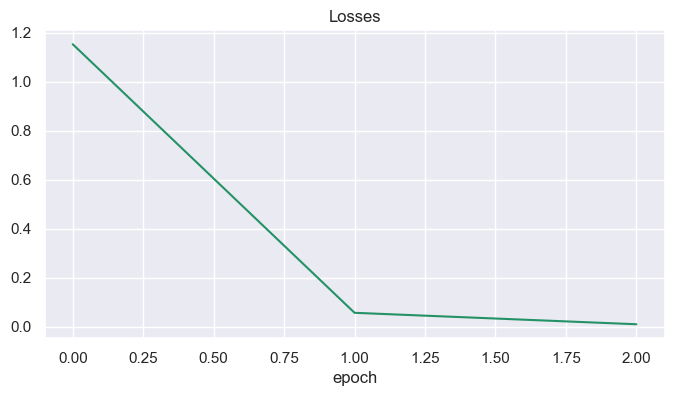

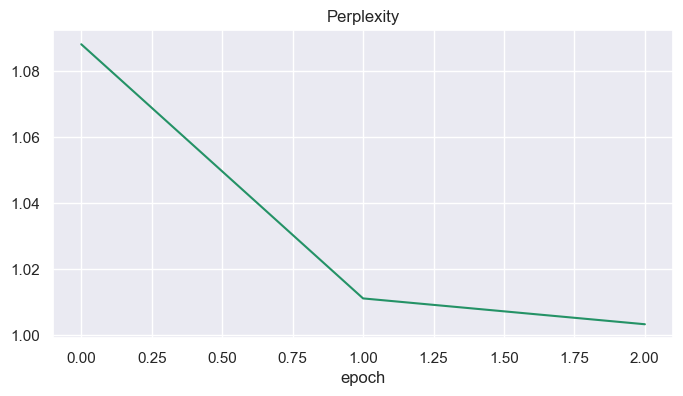

Для 3 эпох:
- Наименьший loss: 0.009427369572222233
- Наименьшая перплексия: 1.0032164916331634
Wall time: 19min 35s


In [136]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 12 модель: LSTM (1 слой) + BiDirect + hidden_size=256 + Add FC

In [137]:
class LanguageModel_v12_LSTM_BiDirect_FC(nn.Module):
    def __init__(self, vocab_size, hidden_size=256):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size*4)
        self.fc2 = nn.Linear(hidden_size*4, hidden_size)
        self.predict = nn.Linear(hidden_size, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.tanh(output)
        
        output = self.fc2(output)
        output = self.dropout(output)
        output = self.tanh(output)
        
        
        output = self.predict(output)
        return output

model = LanguageModel_v12_LSTM_BiDirect_FC(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.15153798460960388
Наименьшая перплексия: 1.077309439966689


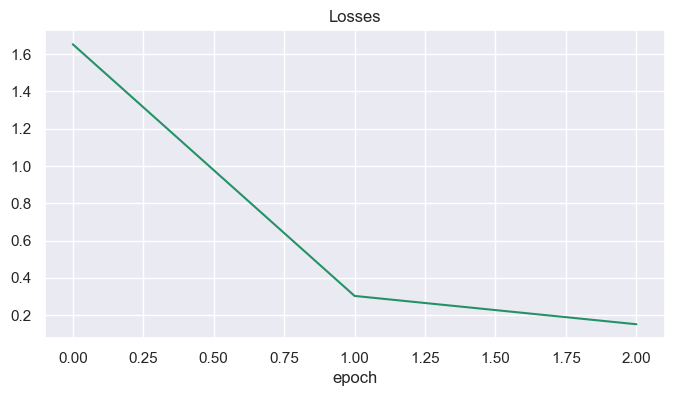

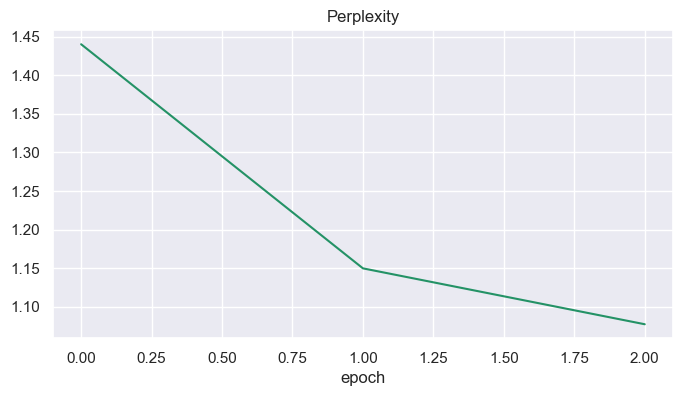

Для 3 эпох:
- Наименьший loss: 0.15153798460960388
- Наименьшая перплексия: 1.077309439966689
Wall time: 11min 18s


In [138]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 13 модель: LSTM (1 слой) + BiDirect + hidden_size=256 + Add FC

In [143]:
class LanguageModel_v13_LSTM_BiDirect_FC(nn.Module):
    def __init__(self, vocab_size, hidden_size=256):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size*2)
        self.fc2 = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.tanh(output)
        
        output = self.fc2(output)
        output = self.dropout(output)
        output = self.tanh(output)
        
        
        output = self.predict(output)
        return output

model = LanguageModel_v13_LSTM_BiDirect_FC(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.007508781272917986
Наименьшая перплексия: 1.007279543778597


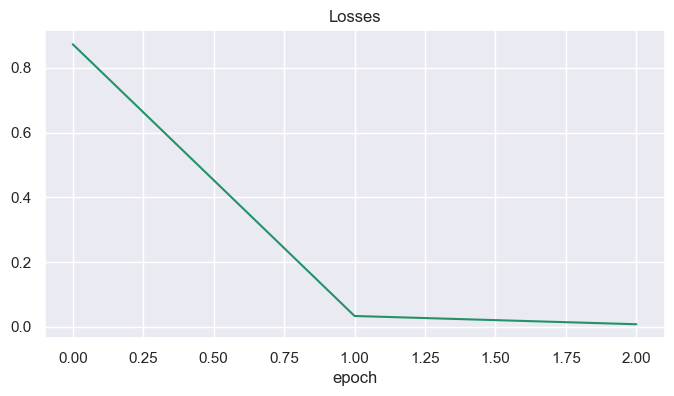

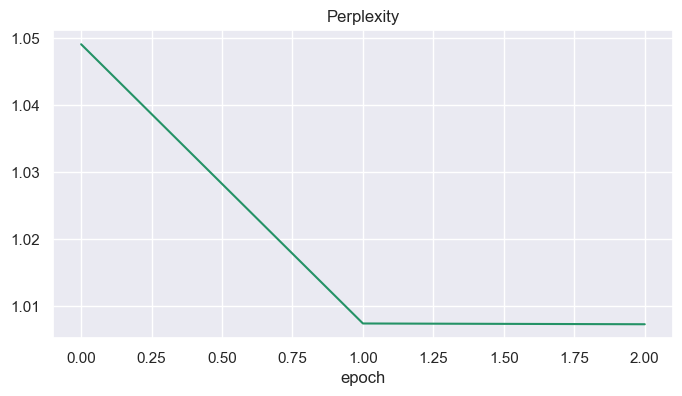

Для 3 эпох:
- Наименьший loss: 0.007508781272917986
- Наименьшая перплексия: 1.007279543778597
Wall time: 27min 11s


In [144]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 14 модель: LSTM (1 слой) + BiDirect + hidden_size=256 + Add FC

In [150]:
class LanguageModel_v14_LSTM_BiDirect_FC(nn.Module):
    def __init__(self, vocab_size, hidden_size=256):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.tanh(output)
        
        output = self.fc2(output)
        output = self.dropout(output)
        output = self.tanh(output)
        
        
        output = self.predict(output)
        return output

model = LanguageModel_v14_LSTM_BiDirect_FC(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.019021648913621902
Наименьшая перплексия: 1.0124692198260006


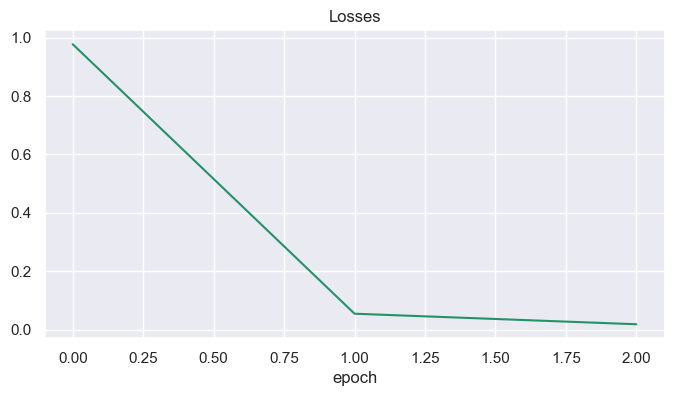

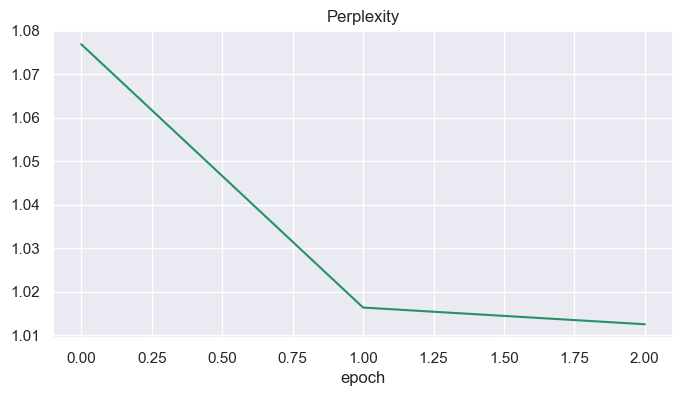

Для 3 эпох:
- Наименьший loss: 0.019021648913621902
- Наименьшая перплексия: 1.0124692198260006
Wall time: 26min 43s


In [151]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 15 модель: LSTM (1 слой) + BiDirect + hidden_size=256

In [157]:
class LanguageModel_v15_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=256):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.tanh(output)
        output = self.predict(output)
        return output

model = LanguageModel_v15_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.0010489909909665585
Наименьшая перплексия: 1.0019557692787864


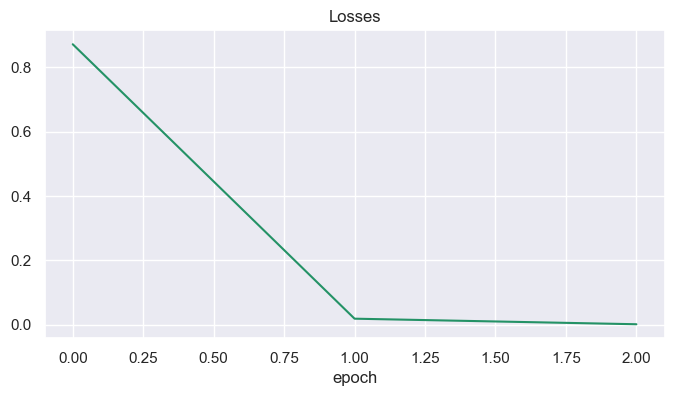

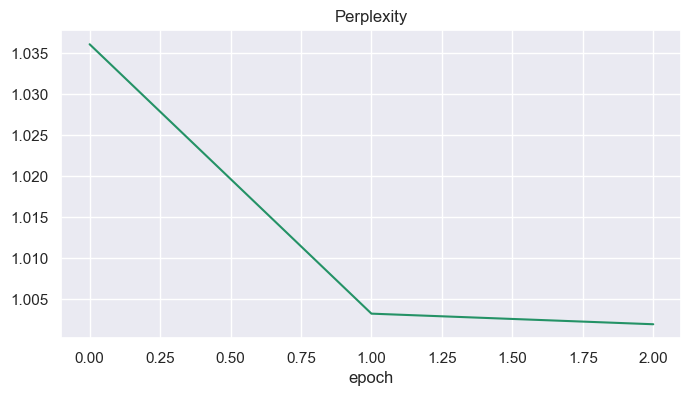

Для 3 эпох:
- Наименьший loss: 0.0010489909909665585
- Наименьшая перплексия: 1.0019557692787864
Wall time: 27min 34s


In [158]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 16 модель: LSTM (1 слой) + BiDirect + hidden_size=128

In [161]:
class LanguageModel_v16_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.tanh(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.tanh(output)
        output = self.predict(output)
        return output

model = LanguageModel_v16_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.00843485351651907
Наименьшая перплексия: 1.003255725810022


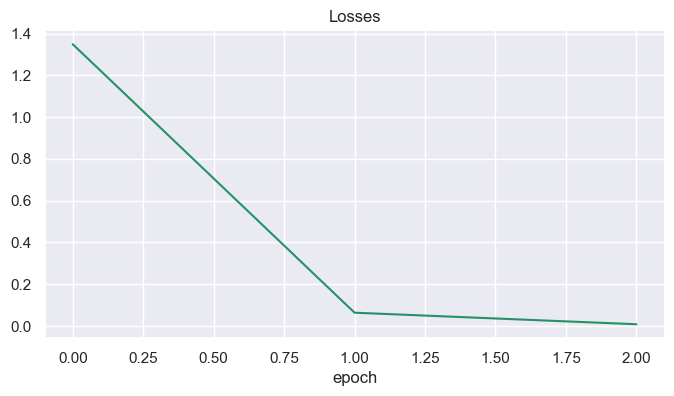

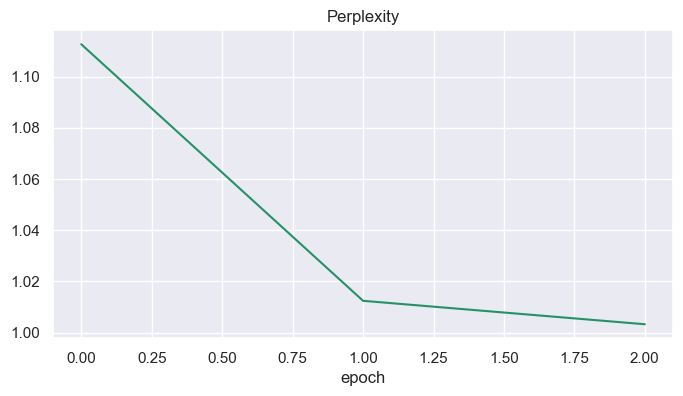

Для 3 эпох:
- Наименьший loss: 0.00843485351651907
- Наименьшая перплексия: 1.003255725810022
Wall time: 14min 59s


In [162]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 17 модель: LSTM (1 слой) + BiDirect + hidden_size=128 SiLU

In [167]:
class LanguageModel_v17_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.SiLU()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

model = LanguageModel_v17_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.07956305891275406
Наименьшая перплексия: 1.035715407236314


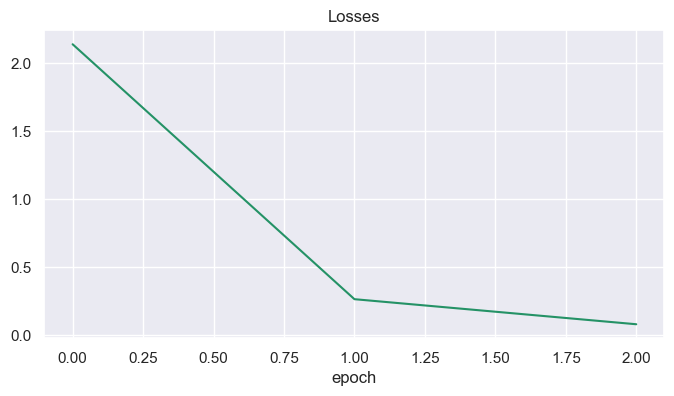

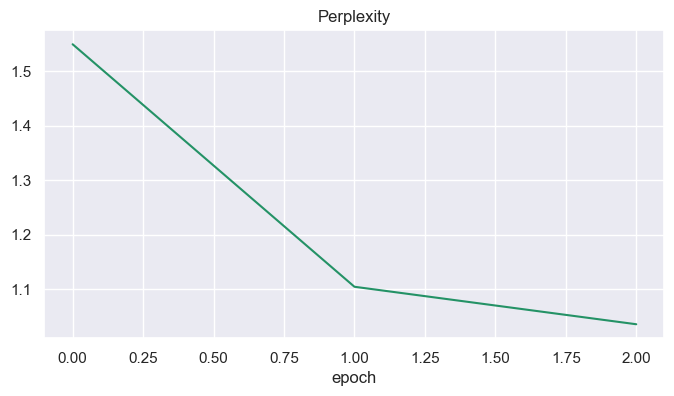

Для 3 эпох:
- Наименьший loss: 0.07956305891275406
- Наименьшая перплексия: 1.035715407236314
Wall time: 15min 42s


In [168]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 18 модель: LSTM (1 слой) + BiDirect + hidden_size=128 ReLU

In [169]:
class LanguageModel_v18_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

model = LanguageModel_v18_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.03571856766939163
Наименьшая перплексия: 1.0130468506317634


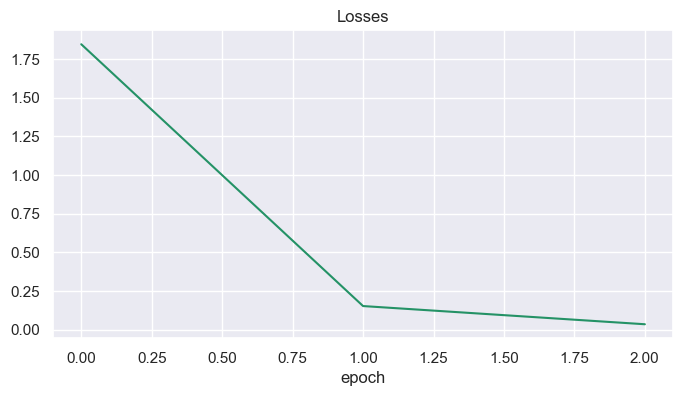

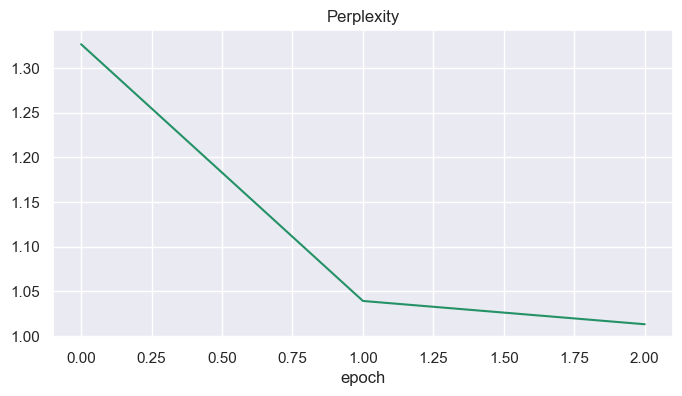

Для 3 эпох:
- Наименьший loss: 0.03571856766939163
- Наименьшая перплексия: 1.0130468506317634
Wall time: 15min 42s


In [170]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 19 модель: LSTM (1 слой) + BiDirect + hidden_size=128 FC DropOut=0.1

In [177]:
class LanguageModel_v19_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

model = LanguageModel_v19_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.004543834365904331
Наименьшая перплексия: 1.0025471279889475


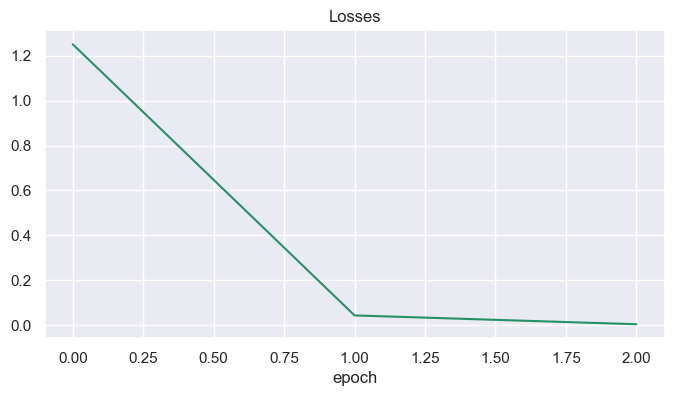

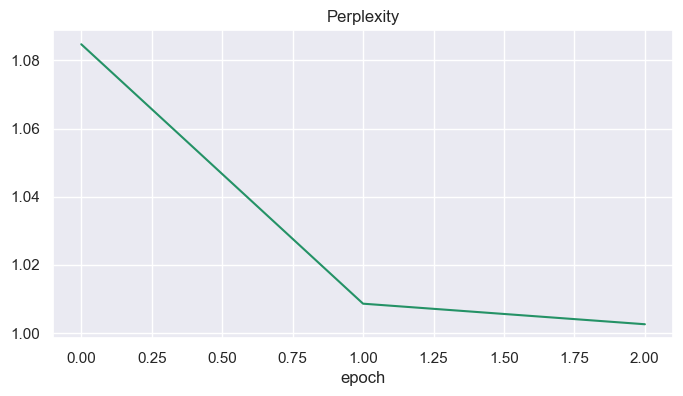

Для 3 эпох:
- Наименьший loss: 0.004543834365904331
- Наименьшая перплексия: 1.0025471279889475
Wall time: 16min


In [178]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 20 модель: LSTM (1 слой) + BiDirect + hidden_size=128 FC DropOut=0.3

In [179]:
class LanguageModel_v20_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()
        self.dropout = nn.Dropout(0.3)
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.fc(output)
        output = self.dropout(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

model = LanguageModel_v20_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.016988147050142288
Наименьшая перплексия: 1.005797028928608


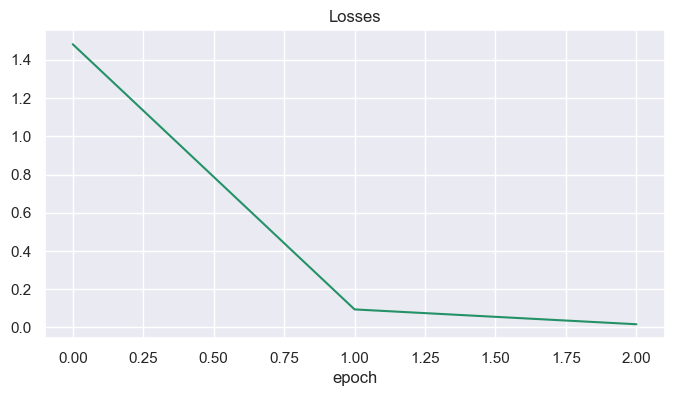

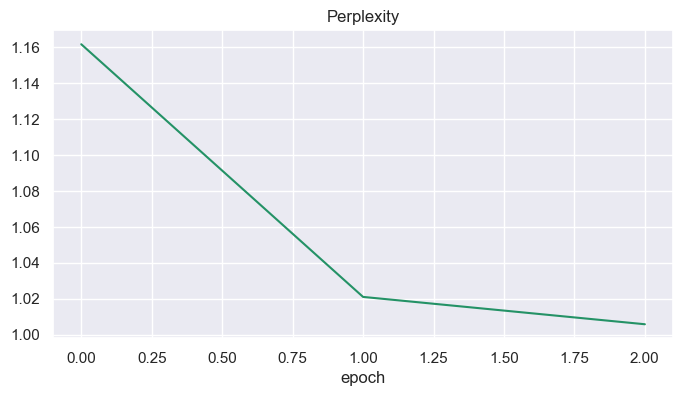

Для 3 эпох:
- Наименьший loss: 0.016988147050142288
- Наименьшая перплексия: 1.005797028928608
Wall time: 17min 20s


In [180]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 21 модель: LSTM (1 слой) + BiDirect + hidden_size=128 Without FC DropOut

In [181]:
class LanguageModel_v21_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

model = LanguageModel_v21_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.0025704519357532263
Наименьшая перплексия: 1.0027033121554882


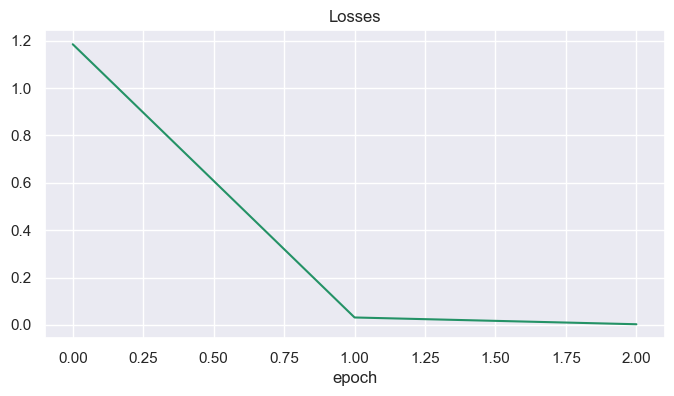

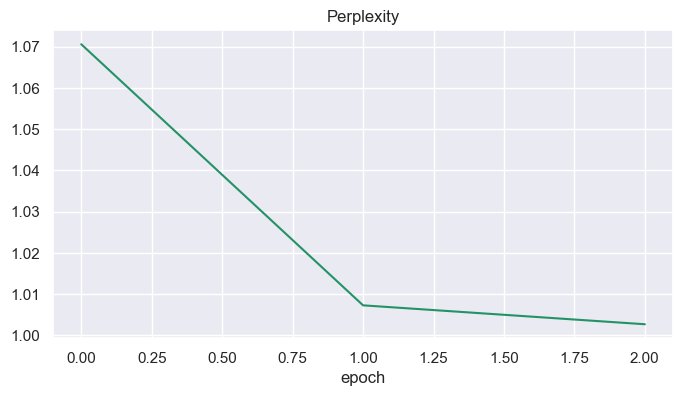

Для 3 эпох:
- Наименьший loss: 0.0025704519357532263
- Наименьшая перплексия: 1.0027033121554882
Wall time: 17min 9s


In [182]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 22 модель: LSTM (2 слой) + BiDirect + hidden_size=128 Without FC DropOut

In [185]:
class LanguageModel_v22_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

model = LanguageModel_v22_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.011701183393597603
Наименьшая перплексия: 1.0075983412854084


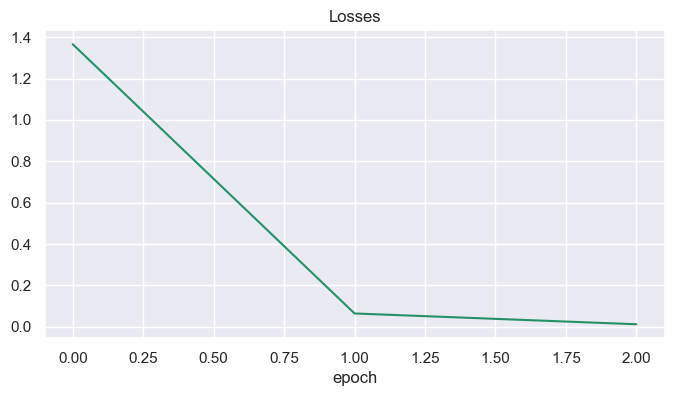

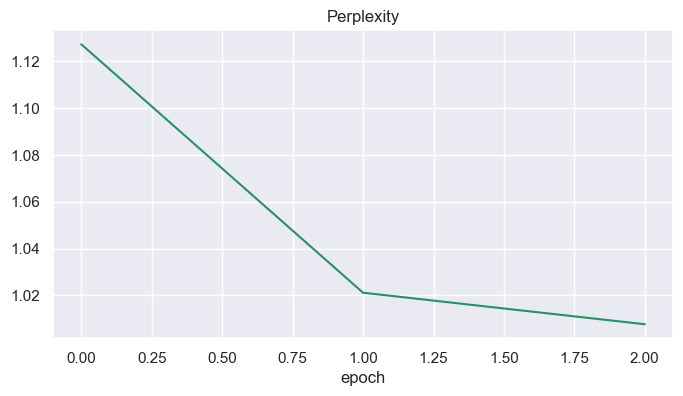

Для 3 эпох:
- Наименьший loss: 0.011701183393597603
- Наименьшая перплексия: 1.0075983412854084
Wall time: 15min 43s


In [186]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 23 модель: LSTM (1 слой) + BiDirect + hidden_size=128 + BatchNorm

In [212]:
class LanguageModel_v23_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        
        self.bn = nn.BatchNorm1d(output.shape[1]).to(device)
        output = self.bn(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

model = LanguageModel_v23_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.0010749709326773882
Наименьшая перплексия: 1.0028229542882927


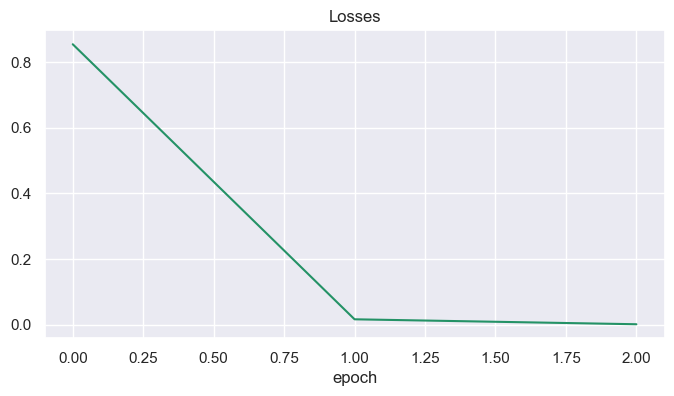

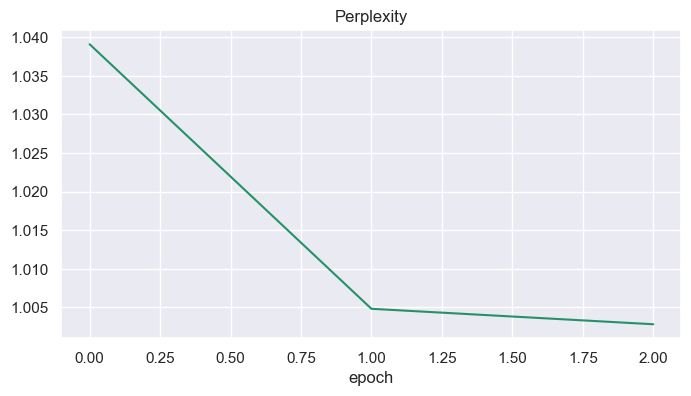

Для 3 эпох:
- Наименьший loss: 0.0010749709326773882
- Наименьшая перплексия: 1.0028229542882927
Wall time: 16min 14s


In [213]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 24 модель: LSTM (1 слой) + BiDirect + hidden_size=64 Without BatchNorm

In [214]:
class LanguageModel_v24_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=64):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

model = LanguageModel_v24_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.028421316295862198
Наименьшая перплексия: 1.0132009820504622


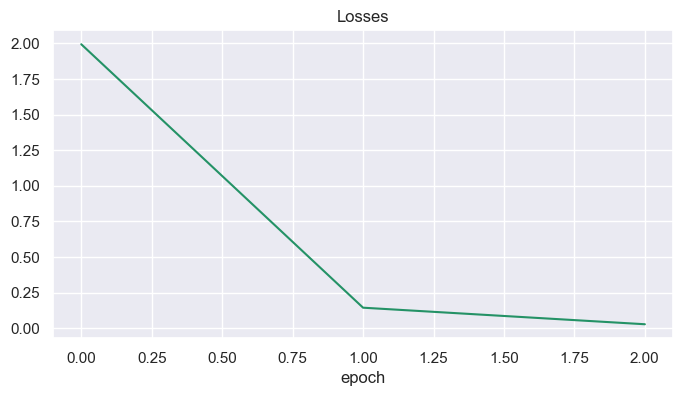

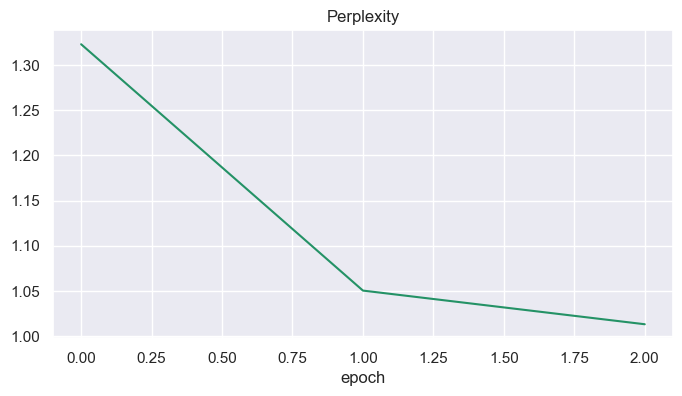

Для 3 эпох:
- Наименьший loss: 0.028421316295862198
- Наименьшая перплексия: 1.0132009820504622
Wall time: 9min 54s


In [215]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 25 модель: LSTM (1 слой) + BiDirect + hidden_size=64 + BatchNorm

In [216]:
class LanguageModel_v25_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=64):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        # self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        # self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        self.bn = nn.BatchNorm1d(output.shape[1]).to(device)
        output = self.bn(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

model = LanguageModel_v25_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 0.010957262478768826
Наименьшая перплексия: 1.0065481973674906


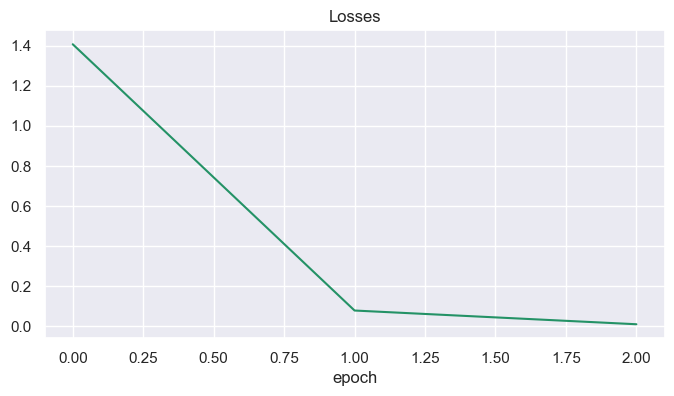

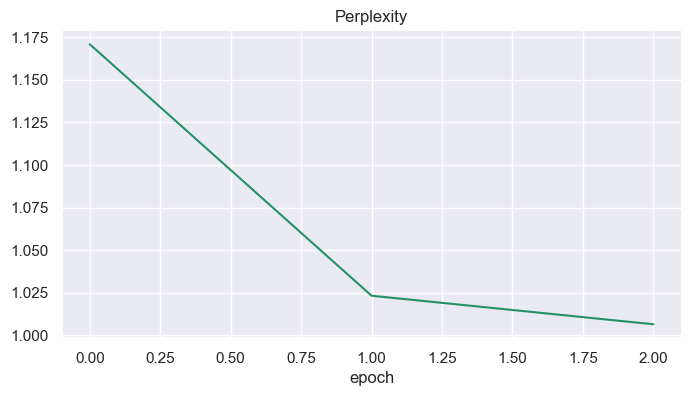

Для 3 эпох:
- Наименьший loss: 0.010957262478768826
- Наименьшая перплексия: 1.0065481973674906
Wall time: 10min 9s


In [217]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()


print_score(losses, perplexites)

#### 26 модель: LSTM (1 слой) + BiDirect + hidden_size=64 + LayerNorm

In [218]:
class LanguageModel_v26_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=64):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()
        

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        x = self.embedding(input_batch)
        # output, _ = self.gru(x)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.layer_norm(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

model = LanguageModel_v26_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.Adam(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


In [219]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

# print(f"Наименьший loss: {min(losses)}")
# plt.figure(figsize=(8,4))
# plt.plot(np.arange(len(losses)), losses)
# plt.title('Losses')
# plt.xlabel("epoch")

# print(f"Наименьшая перплексия: {min(perplexites)}")
# plt.figure(figsize=(8,4))
# plt.plot(np.arange(len(perplexites)), perplexites)
# plt.title('Perplexity')
# plt.xlabel("epoch")
# plt.show()

print_score(losses, perplexites)

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Для 3 эпох:
- Наименьший loss: 0.008626890368759632
- Наименьшая перплексия: 1.005260668533705
Wall time: 10min 4s


#### 27 модель: LSTM (1 слой) + BiDirect + hidden_size=64 Optim=AdamW

In [221]:
class LanguageModel_v26_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        x = self.embedding(input_batch)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.layer_norm(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

torch.manual_seed(53)
np.random.seed(53)

model = LanguageModel_v26_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.AdamW(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [222]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

# print(f"Наименьший loss: {min(losses)}")
# plt.figure(figsize=(8,4))
# plt.plot(np.arange(len(losses)), losses)
# plt.title('Losses')
# plt.xlabel("epoch")

# print(f"Наименьшая перплексия: {min(perplexites)}")
# plt.figure(figsize=(8,4))
# plt.plot(np.arange(len(perplexites)), perplexites)
# plt.title('Perplexity')
# plt.xlabel("epoch")
# plt.show()

print_score(losses, perplexites)

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Для 3 эпох:
- Наименьший loss: 0.008386015892028809
- Наименьшая перплексия: 1.0050067764856083
Wall time: 10min 3s


#### 28 модель: LSTM (1 слой) + BiDirect + hidden_size=64 Optim=SGD

In [224]:
class LanguageModel_v26_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        x = self.embedding(input_batch)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.layer_norm(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

torch.manual_seed(53)
np.random.seed(53)

model = LanguageModel_v26_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.SGD(params=model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [225]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print_score(losses, perplexites)

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Для 3 эпох:
- Наименьший loss: 8.57948112487793
- Наименьшая перплексия: 3875.3130429750913
Wall time: 9min 32s


#### 29 модель: LSTM (1 слой) + BiDirect + hidden_size=64 Optim=RMSprop

In [226]:
class LanguageModel_v26_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        x = self.embedding(input_batch)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.layer_norm(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

torch.manual_seed(53)
np.random.seed(53)

model = LanguageModel_v26_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.RMSprop(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [227]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print_score(losses, perplexites)

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Для 3 эпох:
- Наименьший loss: 0.0529031939804554
- Наименьшая перплексия: 1.0363094103542758
Wall time: 9min 45s


#### 30 модель: LSTM (1 слой) + BiDirect + hidden_size=64 Optim=AdamW lr=1e-2

In [228]:
class LanguageModel_v26_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        x = self.embedding(input_batch)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.layer_norm(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

torch.manual_seed(53)
np.random.seed(53)

model = LanguageModel_v26_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.AdamW(params=model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [229]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print_score(losses, perplexites)

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Для 3 эпох:
- Наименьший loss: 0.038679808378219604
- Наименьшая перплексия: 1.0487040989584737
Wall time: 9min 58s


#### 31 модель: LSTM (1 слой) + BiDirect + hidden_size=64 Optim=AdamW lr=1e-4

In [230]:
class LanguageModel_v26_LSTM_BiDirect(nn.Module):
    def __init__(self, vocab_size, hidden_size=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1, bidirectional=True)
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.fc = nn.Linear(hidden_size*2, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        x = self.embedding(input_batch)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.layer_norm(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

torch.manual_seed(53)
np.random.seed(53)

model = LanguageModel_v26_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.AdamW(params=model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [231]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print_score(losses, perplexites)

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

Для 3 эпох:
- Наименьший loss: 1.3569810390472412
- Наименьшая перплексия: 2.7055893883560644
Wall time: 9min 58s


#### 32 модель: LSTM (1 слой) + BiDirect + hidden_size=64 Макс Длина предложений = 15

In [243]:
torch.manual_seed(53)
np.random.seed(53)

model = LanguageModel_v26_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.AdamW(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [244]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print_score(losses, perplexites)

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/870 [00:00<?, ?it/s]

1


  0%|          | 0/870 [00:00<?, ?it/s]

2


  0%|          | 0/870 [00:00<?, ?it/s]

Для 3 эпох:
- Наименьший loss: 0.08375989645719528
- Наименьшая перплексия: 1.054820902645588
Wall time: 3min 48s


#### 33 модель: LSTM (1 слой) + BiDirect + hidden_size=64 Макс Длина предложений = 35

In [257]:
torch.manual_seed(53)
np.random.seed(53)

model = LanguageModel_v26_LSTM_BiDirect(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.AdamW(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [258]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=3)

print_score(losses, perplexites)

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/1757 [00:00<?, ?it/s]

1


  0%|          | 0/1757 [00:00<?, ?it/s]

2


  0%|          | 0/1757 [00:00<?, ?it/s]

Для 3 эпох:
- Наименьший loss: 0.0034808143973350525
- Наименьшая перплексия: 1.002068920865085
Wall time: 16min 1s


### Финализируем модели и проверяем генерацию

### Генерация
Воспользуемся методом генерации из семинара, но переделаем его под слова вместо символов

In [74]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(char, word2ind['<unk>']) for char in starting_seq]
    
    
    
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(char, word2ind['<unk>']) for char in starting_seq.strip().split(" ")]
    
    input_ids = torch.LongTensor(input_ids).to(device)
    
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break
    
    text = ' '.join([ind2word[idx.item()] for idx in input_ids])
    text = text.replace("<bos>", "").replace("<eos>", "").strip()
    
    
    print(f"in: {starting_seq}")
    print(f"out: {text}")
    print()
    
    return text


#### 34 модель: LSTM (1 слой) + hidden_size=64 Макс Длина предложений = 25

In [346]:
class LanguageModel_v34(nn.Module):
    def __init__(self, vocab_size, hidden_size=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        x = self.embedding(input_batch)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.layer_norm(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output

torch.manual_seed(53)
np.random.seed(53)

model = Languag eModel_v34(vocab_size=len(vocab))
model.to(device)
optim = torch.optim.AdamW(params=model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

  0%|          | 0/10 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

3


  0%|          | 0/1478 [00:00<?, ?it/s]

4


  0%|          | 0/1478 [00:00<?, ?it/s]

5


  0%|          | 0/1478 [00:00<?, ?it/s]

6


  0%|          | 0/1478 [00:00<?, ?it/s]

7


  0%|          | 0/1478 [00:00<?, ?it/s]

8


  0%|          | 0/1478 [00:00<?, ?it/s]

9


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 3.6434168815612793
Наименьшая перплексия: 56.009910405972306


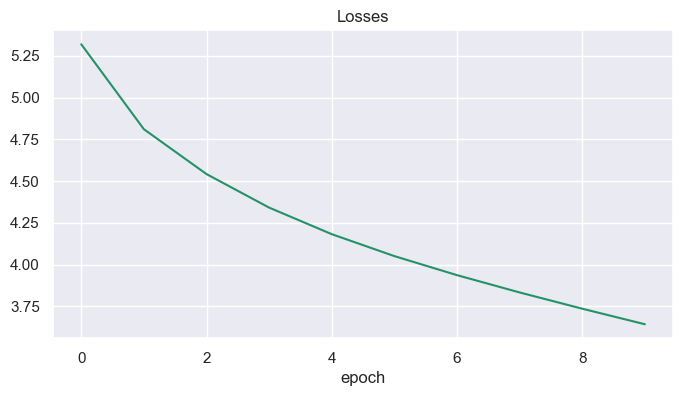

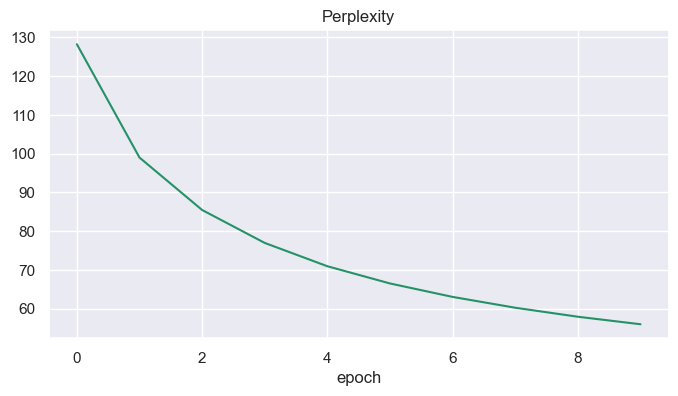

Для 10 эпох:
- Наименьший loss: 3.6434168815612793
- Наименьшая перплексия: 56.009910405972306
Wall time: 1h 32min 3s


In [349]:
%%time
losses, perplexites = train_model(model, optim, criterion, epochs=10)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

print_score(losses, perplexites)

In [350]:
generate_sequence(model, starting_seq='how to load a dataset from ')
generate_sequence(model, starting_seq='you can also find '.strip())
generate_sequence(model, starting_seq='you can '.strip())
generate_sequence(model, starting_seq='bad two things ');


in: how to load a dataset from 
out: how to load a <unk> from the library

in: you can also find
out: you can also find a way to see the movie that is a true test

in: you can
out: you can tell you that you can t tell me what you d think

in: bad two things 
out: bad two things haunt you



  0%|          | 0/20 [00:00<?, ?it/s]

0


  0%|          | 0/1478 [00:00<?, ?it/s]

1


  0%|          | 0/1478 [00:00<?, ?it/s]

2


  0%|          | 0/1478 [00:00<?, ?it/s]

3


  0%|          | 0/1478 [00:00<?, ?it/s]

4


  0%|          | 0/1478 [00:00<?, ?it/s]

5


  0%|          | 0/1478 [00:00<?, ?it/s]

6


  0%|          | 0/1478 [00:00<?, ?it/s]

7


  0%|          | 0/1478 [00:00<?, ?it/s]

8


  0%|          | 0/1478 [00:00<?, ?it/s]

9


  0%|          | 0/1478 [00:00<?, ?it/s]

10


  0%|          | 0/1478 [00:00<?, ?it/s]

11


  0%|          | 0/1478 [00:00<?, ?it/s]

12


  0%|          | 0/1478 [00:00<?, ?it/s]

13


  0%|          | 0/1478 [00:00<?, ?it/s]

14


  0%|          | 0/1478 [00:00<?, ?it/s]

15


  0%|          | 0/1478 [00:00<?, ?it/s]

16


  0%|          | 0/1478 [00:00<?, ?it/s]

17


  0%|          | 0/1478 [00:00<?, ?it/s]

18


  0%|          | 0/1478 [00:00<?, ?it/s]

19


  0%|          | 0/1478 [00:00<?, ?it/s]

Наименьший loss: 2.9339897632598877
Наименьшая перплексия: 48.27221628701016


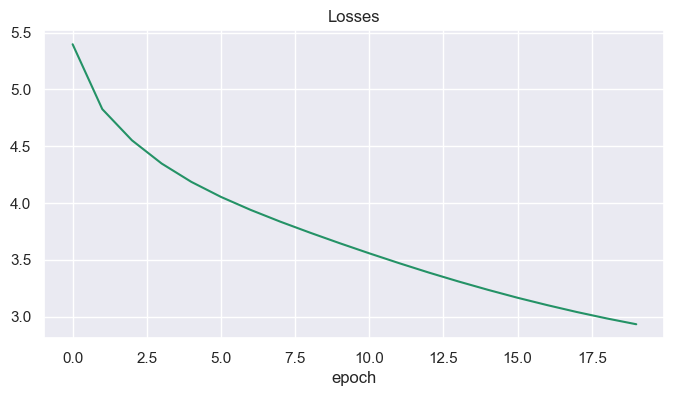

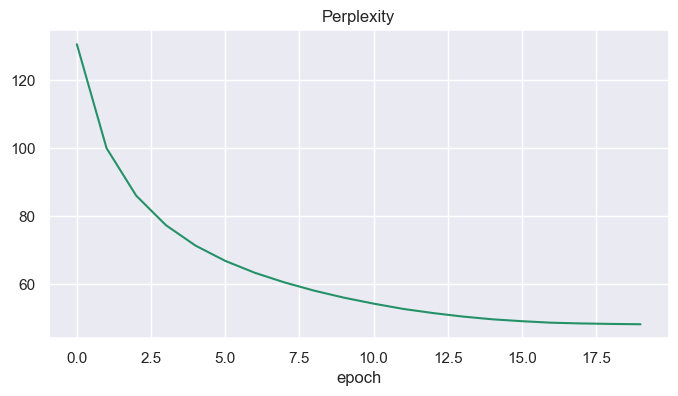

Для 20 эпох:
- Наименьший loss: 2.9339897632598877
- Наименьшая перплексия: 48.27221628701016
Wall time: 3h 8min 45s


In [351]:
%%time


model_34 = LanguageModel_v34(vocab_size=len(vocab))
model_34.to(device)
optim = torch.optim.AdamW(params=model_34.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

losses, perplexites = train_model(model_34, optim, criterion, epochs=20)

print(f"Наименьший loss: {min(losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(perplexites)), perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

print_score(losses, perplexites)

In [352]:
generate_sequence(model_34, starting_seq='how to load a dataset from ')
generate_sequence(model_34, starting_seq='you can also find '.strip())
generate_sequence(model_34, starting_seq='you can '.strip())
generate_sequence(model_34, starting_seq='bad two things ');


in: how to load a dataset from 
out: how to load a <unk> from this man

in: you can also find
out: you can also find the outcome to hugging the world of the individual

in: you can
out: you can tell you how old kay pollak and alive

in: bad two things 
out: bad two things haunt you throughout



In [353]:
print_score(losses, perplexites)

Для 20 эпох:
- Наименьший loss: 2.9339897632598877
- Наименьшая перплексия: 48.27221628701016


In [356]:
print_score(losses, perplexites, fix_epoches=7)

Для 7 эпох:
- Наименьший loss: 3.939910650253296
- Наименьшая перплексия: 63.4156253946808


In [355]:
print_score(losses, perplexites, fix_epoches=3)

Для 3 эпох:
- Наименьший loss: 4.5518879890441895
- Наименьшая перплексия: 86.10528700692313


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 

##### Подгтовка данных
Разметка предложений в исходном датасете не очевидная, местами в качестве раздлеления предложений используются тэг <br> или "...". Поэтому перед обучением модели был предобработан датасет:
- использовались только слова без цифр и спецсимволов, другие отбрасывались
- все тэги переведены в символ конца предложения "."
- все "...", "?", "!" заменены на  "."
- отбросились все предложения меньше 4 и больше 25 слов

Распределение длины предложений:
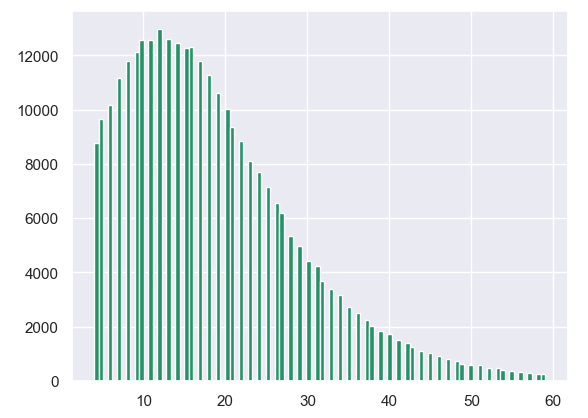


##### Базовая модель (baseline)
Для 20 эпох:
- Наименьший loss: 4.694701671600342  
- Наименьшая перплексия: 104.05185881115142  

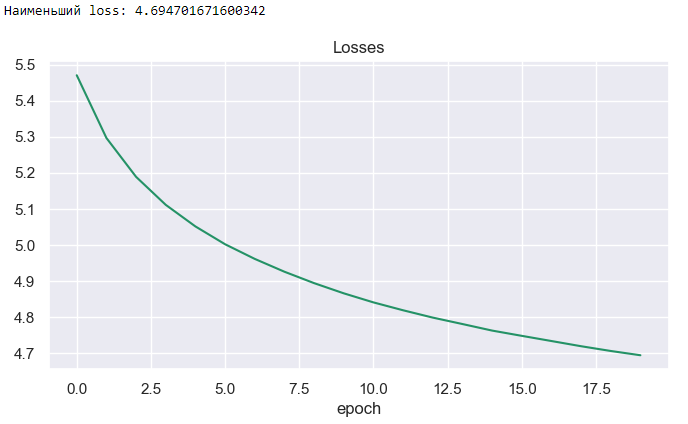
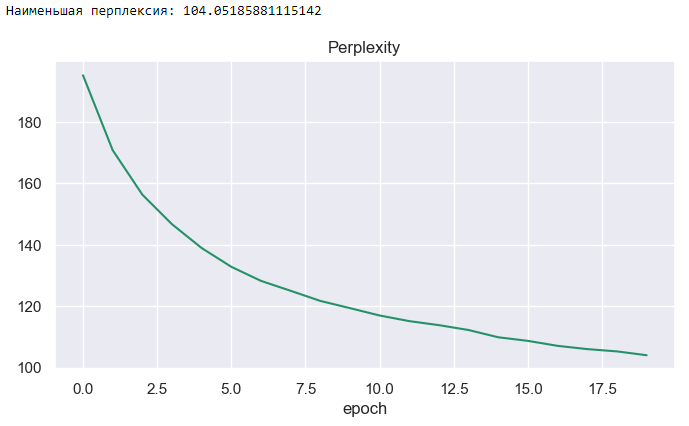

По графикам лосса и перплексии видно, что чем больше эпох, тем ниже (лучше) эти показатели.
Однако 20 эпох довольно долго считаются, поэтому все эксперименты будем проводить на более меньшем кол-ве эпох, например 7, а уже для конечной модели увеличим число эпох.    
Для 7 эпох у базовой модели показатели:  
- Наименьший loss: 4.961692810058594  
- Наименьшая перплексия: 128.27027759304295  

##### Базовая модель c GRU вместо RNN.
Для 7 эпох:  
- Наименьший loss: 4.943782806396484  
- Наименьшая перплексия: 125.11486988150196  

##### Базовая модель c LSTM вместо RNN.
Для 7 эпох:  
- Наименьший loss: 4.943782806396484  
- Наименьшая перплексия: 125.11486988150196  



##### Предварительный итог: Выбор кол-ва слоев
Сравнение для 7 эпох, LSTM (произведена небольшая оптимизация и время рассчета для LSTM снизилось с 4 до 2 минут)
* LSTM 1 внутренний слой:  
    - Наименьший loss: 4.939565181732178
    - Наименьшая перплексия: 124.8495824491823    
    - 1 эпоха считается ~ 2:31
* LSTM 2 внутренних слоя:  
    - Наименьший loss: 5.045697212219238
    - Наименьшая перплексия: 139.97499896953633    
    - 1 эпоха считается ~ 2:32
* LSTM 4 внутренних слоя:  
    - Наименьший loss: 5.150515079498291
    - Наименьшая перплексия: 157.9109002811052
    - 1 эпоха считается ~ 2:53-3:36


При повышении слоев ухудшились лосс и перплексия. Скорее всего это связано с затуханием градиента.  
#### Проверяем затухание градиента

##### Рапределение градиентов для модели с 1 слоем LSTM (3 эпохи)
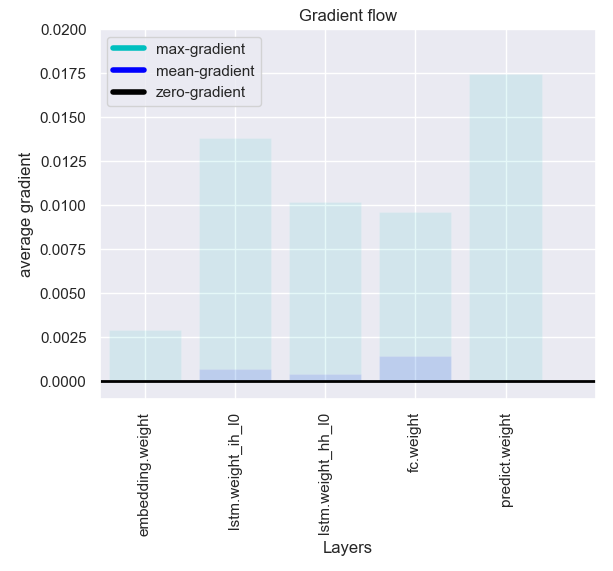

##### Рапределение градиентов для модели с 4 слоями LSTM (3 эпохи)
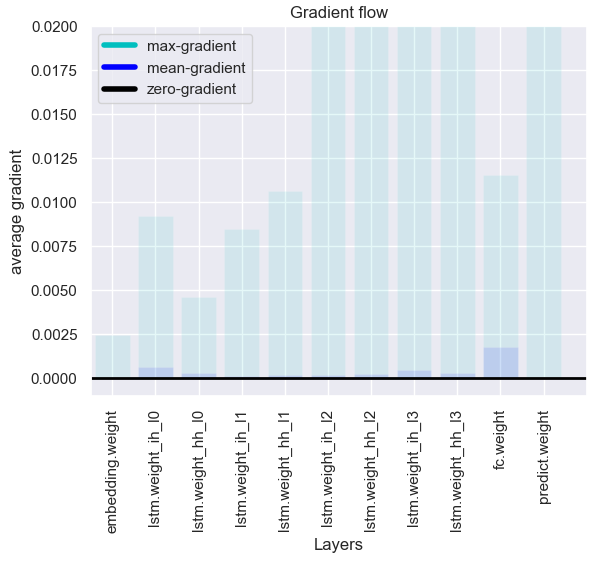

Заметно, что при 4х внутренних слоях LSTM внутриние слои среднее значание градиента очень мало, т.е. градиент внутринние слои LSTM в данной конфигурации плохо обучаются, необходмио изменить модель либо изменить данные (длина предложений или размер словаря).


#### BiDirectional 
Добавление Двунаправленого прохода значительно улучшает модель лосс и перплексия имеют значительное снижение:  
- Снижение Loss c 5.26 до 0.58 (для 3 эпох)
- Снижение Perplexity c 166.82 до 1.45 (для 3 эпох)

#### BiDirectional + 2 NumLayers
Т.к. при увеличении слоев была проблема затухания градиента, то с учетом добавления biderct необходимо повторно проверить возможность увеличения кол-ва слоев рекурентной сети вместе с biderect. Однако опять увеличение слоев хуже отразилось на работе модели.
- Loss c 0.58 увеличился до 1.49 (для 3 эпох)
- Perplexity c 1.45  увеличился до 2.87 (для 3 эпох)

#### Размер скрытого состояния
Изначально размер скрытого состояния был 128.
Увеличение до 256 улучшило модель:
- Снижение Loss c 0.58 до 0.097 (для 3 эпох)
- Снижение Perplexity c 1.45 до 1.038 (для 3 эпох)

Увеличение до 512 улучшило модель:
- Снижение Loss c 0.58 до 0.0094 (для 3 эпох)
- Снижение Perplexity c 1.45 до 1.003 (для 3 эпох)

При полвышении размера вектора скрытых состояний модель работает лучше, но дольше, для дальнейших экспериментов будет оставлен размер 256, а уже в финальную модель будет заложен размер 512. С другой стороны разница по точности 256 с 512 не сильная, но зато 256 значительно быстрее.

#### Добавлен дополнительный линейный слой после RNN-блока. 
Добавлен FC слой (+активация + дропаут).
1. В варинат №1 заложена следующая логика:
- Из LSTM-блока получается вектор размера hidden_size*2 (т.к. используется BiDirect)
- 1-ый FC слой переводит из hidden_size*2 в hidden_size*4
- 2-ой FC слой переводит из hidden_size*4 в hidden_size
- Финальный вывод переводит из hidden_size в vocab_size
Этот вариант ожидаемо плохо сработал. Это связано с тем что итоговый размер словаря (vocab) довольно большой (несколько десятков тысяч слов) которые надо предсказывать, и соответственно чем из вектора большей размерности мы придем к словарю тем проще модели будет сделать сопоставление на выходном FC слое. (короче из 256 в 30000 перейти тяжелее, чем из 512 в 30000)

2. В варинате №2 изменения в конце:
- 1-ый FC слой переводит из hidden_size*2 в hidden_size*2
- 2-ой FC слой переводит из hidden_size*2 в hidden_size*4
- Финальный вывод переводит из hidden_size*4 в vocab_size

Этот вариант дал значительный прирост:  
- Снижение Loss c 0.097 до 0.0075 (для 3 эпох)
- Снижение Perplexity c 1.038 до 1.0072 (для 3 эпох)
Однако время обработки одной эпохи увеличилось в два раза до 7,5 минут
Т.е. hidden_size*2 => hidden_size*2 => hidden_size*4 => vocab_size

3. В варинате №3 изменения:
- 1-ый FC слой переводит из hidden_size*2 в hidden_size*1
- 2-ой FC слой переводит из hidden_size*1 в hidden_size*4
- Финальный вывод переводит из hidden_size*4 в vocab_size
Эмитация бутылосного горлошка. Этот варинат дал прирост до (лосс:0.019,	перплексия: 1.012), но по времени также 7,5 минут


4. В варинате №4 не добавляется новый FC слой но изменяется размерность сущесвтующих:
- Из LSTM-блока получается вектор размера hidden_size*2 (т.к. используется BiDirect)
- FC слой переводит из hidden_size*2 в hidden_size*4
- Финальный вывод переводит из hidden_size*4 в vocab_size
Т.е. hidden_size*2 => hidden_size*4 => vocab_size
Этот вариант дал значительный прирост, но по времени также 7,5 минут:  
- Снижение Loss c 0.097 до 0.0010(для 3 эпох)
- Снижение Perplexity c 1.038 до 1.0019 (для 3 эпох)

При увеличении размера FC слоя модель работает значительно лучше, но и заметно дольше. Для дальнейших экспериментов будет понижен размер вектора скрытых состояний с 256 до 128, а уже в финальную модель будет заложен размер 256 или 512.

####  Различные функции активации.
Функции активации проверялись на размере вектора скрытых состояний 128 (чтобы компенсировать время проверки)
1. По умолчанию испоьзовалась ф-ция активации Tanh
- Loss: 0.0084
- Perplexity: 1.0032
2. Проверялся вариант ф-ции  активации SiLU
- Loss: 0.079
- Perplexity: 1.035
3. Проверялся вариант ф-ции  активации ReLU
- Loss: 0.035
- Perplexity: 1.013
По итогам проверки Tanh показал лучшее качество модели.

####  Добавление нормализаций в виде Dropout
1. По умолчанию использовался слой Dropout для FC с p=0.2
- Loss: 0.0084
- Perplexity: 1.0032
2. Слой Dropout для FC с p=0.1
- Loss: 0.0045
- Perplexity: 1.0025
3. Слой Dropout для FC с p=0.3
- Loss: 0.0169
- Perplexity: 1.0057	
4. Без Dropout для FC
- Loss: 0.0025
- Perplexity: 1.0027

Dropout для RNN/LSTM имеет смысл указывать когда заданы больше одного внутренних слоя, чтобы было для чего dropout делать.
В нашем случае используется 1 слой LSTM, для проверки возможности использования dropout надо заново проверить эффект от добавления еще одного слоя. После множественных изменений модели, второй слой может дать пользу (до этого он показал себя хуже).

5. Без Dropout для FC, но 2 слоя LSTM
- Loss: 0.0117
- Perplexity: 1.0075

####  Добавление слой нормализации 
1. BatchNorm с размером вектора скрытых состояний = 128
- Loss: 0.0010
- Perplexity: 1.0028
Учитывая, что предложения в каждом бачте приходят различной длины, а для BN нужно указывать размер, пришлось иницилизацию BN делать внутри forward

Значения лосса и перплексии сильно уменьшаются затрудняет делать по ним оценку изменений. Так как время расчета принципиально для проведения экспериментов можно еще уменьшить размер вектора скрытых состояний до 64 (чтобы компенсировать время проверки). А для финальной модели обратно повысить.

2. Без BatchNorm модель с размером вектора скрытых состояний = 64
- Loss: 0.0284
- Perplexity: 1.0132

3. Включая BatchNorm модель  с размером вектора скрытых состояний = 64
- Loss: 0.0109
- Perplexity: 1.0065

4. LayerNorm
- Loss: 0.0086
- Perplexity: 1.0052

####  Выбор оптимизатора (Adam по умолчанию)
1. Adam
- Loss: 0.0086
- Perplexity: 1.0052

2. AdamW
- Loss: 0.0083
- Perplexity: 1.0050

3. SGD
- Loss: 8.57
- Perplexity: 3875.31

4. RMSProp
- Loss: 0.0529
- Perplexity: 1.0363

В итоге SGD и RMSProp показали себя хуэе всего. Adam и AdamW примерно одинаковые, AdamW немного лучше.

####  learning rate (по умолчанию learning rate=1e-3 = 0.001)
1. learning rate=0.001
- Loss: 0.0083
- Perplexity: 1.0050

2. learning rate=0.01
- Loss: 0.0386
- Perplexity: 1.0487

3. learning rate=0.0001
- Loss: 1.3569
- Perplexity: 2.7055


####  Различная максимальная длина предложений (по умолчанию max_word_threshold = 25 слов)
1. max_word_threshold = 25
- Loss: 0.0083
- Perplexity: 1.0050

2. max_word_threshold = 15
- Loss: 0.0837
- Perplexity: 1.0548

3. max_word_threshold = 35
- Loss: 0.0034
- Perplexity: 1.0020

Максимальная длина предложений = 35 лучше, но сильно дольше считает (~ в 2 раза), также 35 это уже слишком длинное предложение, поэтому выбор остается на размере 25 слов.

#### Проверка генерации текста.
При попытках сгенерировать текст, возникли проблемы. Оказалось, что была плохая идея использовать BiDirect, он очень плохо влияет на модель. Т.е.модель попросту не может сгенерировать следующее слово. И если начать рассуждать, то становится понятно, что для генерации текста использовать обратный проход не очень верно, и также понятно почему в итоге BiDirect дал очень хорошие результаты по точности. Вероятно есть способы использовать BiDirect в задаче генерации, эту тему необходимо изучить отдельно.

После исключения BiDirect и повторного обучения, модели начали что-то генерировать.

Пример слабой модели:
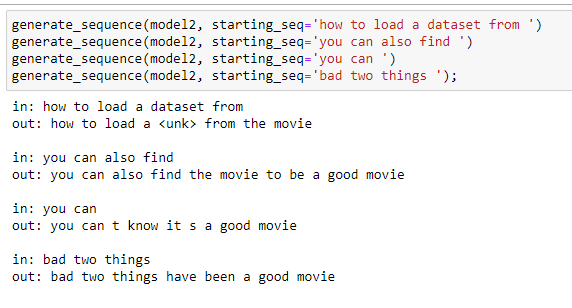
Видно что пркатически везде однотипное продолжение "good movie"

Пример модели посильнее:
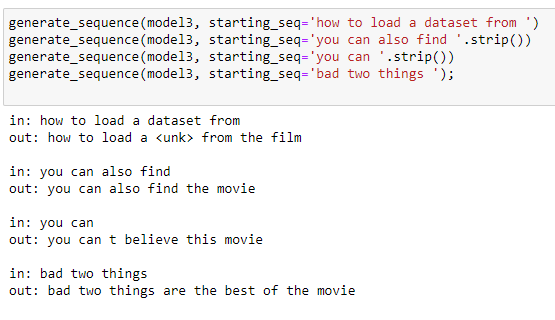
Заметно, что модель генерирует уже более разнообразные варианты текста.




#### Итоговая модель
Настройки:
- Рекурентный слой = LSTM
- Кол-во внутренних слоев LSTM = 1
- Размер скрытого состояния: 256 
- Оптимизатор = AdamW
- BiDirect = False
- Без дропаута
- learning rate = 1e-3
- Максимальная длина предложений = 25

График обучения:
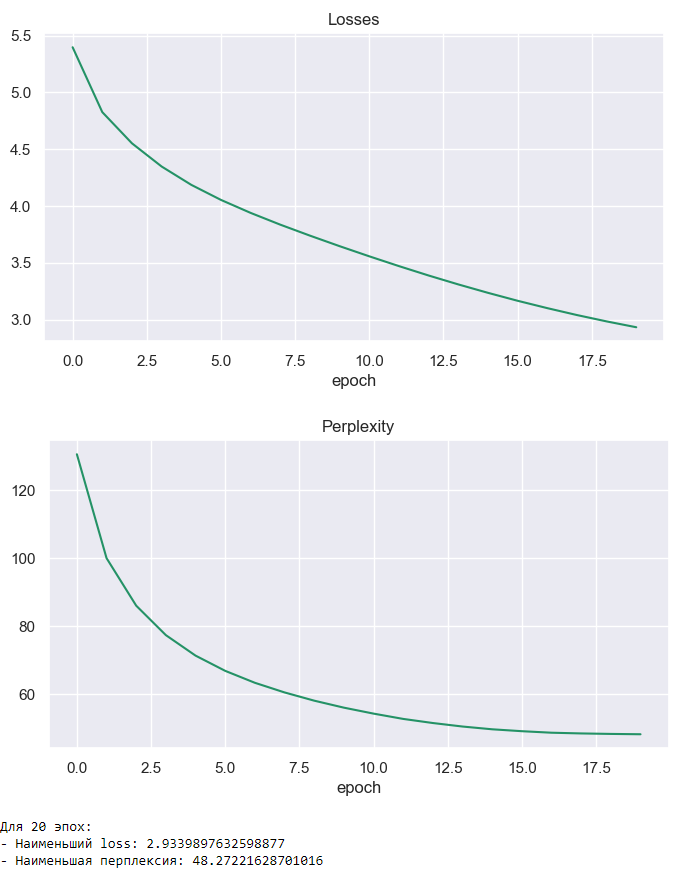

По графикам видно, что переобучение еще не наступает и можно увеличить кол-во эпох, однако это уже сильно затратно по времени.  

Для 10 эпох:
- Наименьший loss: 3.6434168815612793
- Наименьшая перплексия: 56.009910405972306
- Время обучения: 1h 32min 3s

Для 20 эпох:
- Наименьший loss: 2.9339897632598877
- Наименьшая перплексия: 48.27221628701016
- Время обучения: 3h 8min 45s


Проверка генерации текста:
Была дополнительная проверка генерации итоговой модели на 10 эпохах:
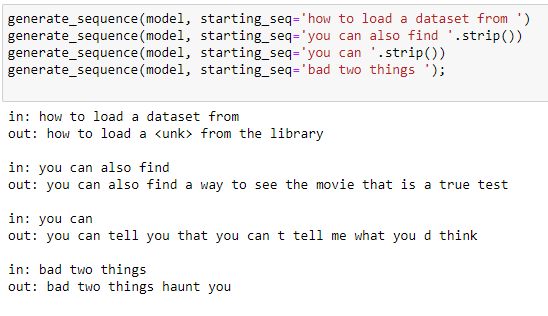


Итоговая модель на 20 эпохах
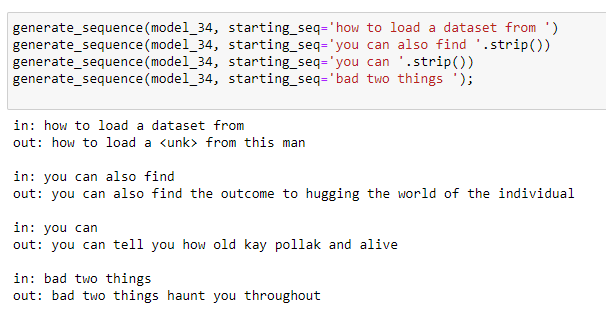

Подбор параметров и эксперименты проводились с подходом "Жадный алгоритм", т.е. на каждом шаге выбирались лучшие показатели среди выбранных варинатов. По хорошему, после выбора архитектуры, подбор гиперпараметров можно реализовать с помощью GridSearch, но это будет затратно по времени, с учетом большого кол-ва параметров и их комбинаций.



### Итоговая таблица с результатами эксперементов

|#|RNN_Type|descript|Optim|LR|epochs|nums <br>RNN <br>layers|bidirect|hidden <br>size|loss|perplexity|~time per <br>1 epoch|
|---|---|---|---|---|---|---|---|---|---|---|---|
|1|RNN|Базовая модель <br> (ф-ция активации Tanh) <br> FC_dropout=0.2 <br> 7 эпох|Adam|1e-3|7|1|-|128|4.96|128.27|< 3min|
|2|GRU|Базовая модель|Adam|1e-3|7|1|-|128|4.94|125.11|< 3min|
|3|LSTM|Базовая модель|Adam|1e-3|7|1|-|128|4.93|124.84|< 3min|
|4|LSTM|Базовая модель|Adam|1e-3|7|2|-|128|5.04|139.97|< 3min|
|5|LSTM|Базовая модель|Adam|1e-3|7|4|-|128|5.15|157.91|< 3min|
|3'|LSTM|Модель №3 + <br>+ Проверка градиентов <br> 3 эпохи|Adam|1e-3|3|1|-|128|5.26|166.82|< 3min|
|4'|LSTM|Модель №4 + <br>+ Проверка градиентов|Adam|1e-3|3|2|-|128|5.41|193.92|< 3min|
|5'|LSTM|Модель №5 + <br>+ Проверка градиентов|Adam|1e-3|3|4|-|128|5.65|245.63|< 3min|
|6|LSTM|Модель №3' + убрана <br> активация после LSTM|Adam|1e-3|3|1|-|128|5.31|187.64|< 3min|
|7|LSTM|Модель №3' + <br>+ BiDirect|Adam|1e-3|3|1|+|128|0.58|1.45|< 3min|
|8|LSTM|Модель №7 + <br>+ 2 слоя|Adam|1e-3|3|2|+|128|1.49|2.87|02:14|
|9|LSTM|Модель №7 + <br>+ размер скрытого <br> состояния 256 вместо 128|Adam|1e-3|3|1|+|256|0.097|1.038|03:00|
|10|LSTM|Модель №9 + <br> + 2 слоя <br>|Adam|1e-3|3|2|+|256|0.51|1.43|03:29|
|11*|LSTM|Модель №7 + <br>+ размер скрытого <br> состояния 512 вместо 128|Adam|1e-3|3|1|+|512|0.0094|1.003|05:26|
|12|LSTM|Модель №9 + <br>+ добавлен еще 1 FC <br>hidden_size\*2=>hs=>vocab_size|Adam|1e-3|3|1|+|256|0.151|1.077|03:05|
|13|LSTM|Модель №9 + <br>+ добавлен еще 1 FC <br>hs\*2=>hs\*2=>hs\*4=>vocab_size|Adam|1e-3|3|1|+|256|0.0075|1.0072|07:33|
|14|LSTM|Модель №9 + <br>+ добавлен еще 1 FC <br>hs\*2=>hs=>hs\*4=>vocab_size|Adam|1e-3|3|1|+|256|0.019|1.012|07:25|
|15**|LSTM|Модель №9 + <br>+ изенен существующий FC <br>hs\*2=>hs\*4=>vocab_size|Adam|1e-3|3|1|+|256|0.00104|1.0019|07:35|
|16|LSTM|Модель №15 + <br>+ изенен размер скрытого <br> состояния на 128|Adam|1e-3|3|1|+|128|0.0084|1.0032|04:05|
|17|LSTM|Модель №16 + <br>+ ф-ция активации SiLU|Adam|1e-3|3|1|+|128|0.079|1.035|04:14|
|18|LSTM|Модель №16 + <br>+ ф-ция активации ReLU|Adam|1e-3|3|1|+|128|0.035|1.013|04:14|
|19|LSTM|Модель №16 + <br>+ FC_dropout=0.1|Adam|1e-3|3|1|+|128|0.0045|1.0025|04:26|
|20|LSTM|Модель №16 + <br>+ FC_dropout=0.3|Adam|1e-3|3|1|+|128|0.0169|1.0057|04:50|
|21|LSTM|Модель №16 + <br>+ FC_dropout=без дропаута FC|Adam|1e-3|3|1|+|128|0.0025|1.0027|04:40|
|22|LSTM|Модель №21 + <br>+ 2 слоя|Adam|1e-3|3|2|+|128|0.0117|1.0075|04:15|
|23|LSTM|Модель №21 + <br>+ BatchNormal|Adam|1e-3|3|1|+|128|0.0010|1.0028|04:30|
|24***|LSTM|Модель №21 + <br>+ изенен размер скрытого <br> состояния на 64|Adam|1e-3|3|1|+|64|0.0284|1.0132|02:40|
|25|LSTM|Модель №24 + <br>+ BatchNormal|Adam|1e-3|3|1|+|64|0.0109|1.0065|02:45|
|26|LSTM|Модель №24 + <br>+ LayerNorm|Adam|1e-3|3|1|+|64|0.0086|1.0052|02:45|
|27|LSTM|Модель №26 + <br>+ AdamW|AdamW|1e-3|3|1|+|64|0.0083|1.0050|02:45|
|28|LSTM|Модель №26 + <br>+ SGD|SGD|1e-3|3|1|+|64|8.5794|3875.3130|02:35|
|29|LSTM|Модель №26 + <br>+ RMSprop|RMSprop|1e-3|3|1|+|64|0.05290|1.0363|02:40|
|30|LSTM|Модель №27 + <br>+ lr=1e-2|AdamW|1e-2|3|1|+|64|0.0386|1.0487|02:44|
|31|LSTM|Модель №27 + <br>+ lr=1e-4|AdamW|1e-4|3|1|+|64|1.3569|2.7055|02:44|
|32|LSTM|Модель №27 + <br>+ максимальная длина предложений = 15|AdamW|1e-3|3|1|+|64|0.0837|1.0548|01:02|
|33|LSTM|Модель №27 + <br>+ максимальная длина предложений = 35|AdamW|1e-3|3|1|+|64|0.0034|1.0020|04:23|
|34\*\*\*\*|LSTM|Модель №27|AdamW|1e-3|3|1|-|64|3.64|56.09|07:33|
|34'|LSTM|Модель №27, 7 эпох|AdamW|1e-3|7|1|-|64|3.93|63.41|07:33|
|34''|LSTM|Модель №27, 20 эпох|AdamW|1e-3|20|1|-|64|2.93|48.27|07:33|


- 11* При полвышении размера вектора скрытых состояний модель работает лучше, но дольше, для дальнейших экспериментов будет оставлен размер 256, а уже в финальную модель будет заложен размер 512 (если потребуется и будет позволять время расчета одной эпохи).  
- 15** При увеличении размера FC слоя модель работает значительно лучше, но и заметно дольше. Для дальнейших экспериментов будет понижен размер вектора скрытых состояний с 256 до 128, а уже в финальную модель будет заложен размер 256.  
- 24*** Значения лосса и перплексии сильно уменьшаются затрудняет делать по ним оценку изменений. Так как время расчета принципиально для проведения экспериментов можно еще уменьшить размер вектора скрытых состояний до 64 (чтобы компенсировать время проверки). А для финальной модели обратно повысить.  
- 34**** При попытках сгенерировать текст, возникли проблемы. Оказалось, что была плохая идея использовать BiDirect, он очень плохо влияет на модель. Т.е.модель попросту не может сгенерировать следующее слово. И если начать рассуждать, то становится понятно, что для генерации текста использовать обратный проход не очень верно, и также понятно почему в итоге BiDirect дал очень хорошие результаты по точности. Вероятно есть способы использовать BiDirect в задаче генерации, эту тему необходимо изучить отдельно. А теперь необходимо выбрать оптимальную модель без учета BiDirect, используем все выбранные показатели отключив BiDirect.


Выбираем итоговые настройки
- Рекурентный слой = LSTM
- Кол-во внутренних слоев LSTM = 1
- Размер скрытого состояния: 256
- Оптимизатор = AdamW
- BiDirect = False
- Без дропаута
- learning rate = 1e-3
- Максимальная длина предложений = 25




### Bonus (русский язык)
Давайте попробуем обучить выбранную архитекутру на русских текстах (датасет из семинара)

In [8]:
rus_dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0", cache_dir="/datasets/gazeta_dataset")

No config specified, defaulting to: gazeta/default
Found cached dataset gazeta (D:/datasets/gazeta_dataset/IlyaGusev___gazeta/default/1.0.0/ef9349c3c0f3112ca4036520d76c4bc1b8a79d30bc29643c6cae5a094d44e457)


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
rus_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title', 'date', 'url'],
        num_rows: 52400
    })
    test: Dataset({
        features: ['text', 'summary', 'title', 'date', 'url'],
        num_rows: 5770
    })
    validation: Dataset({
        features: ['text', 'summary', 'title', 'date', 'url'],
        num_rows: 5265
    })
})

In [10]:
# Смотрим что вообще внутри обучающей выборки и как текст бьется на предложения
first_item = next(iter(rus_dataset["train"]))
sents_item = nltk.sent_tokenize(first_item["text"])
len(sents_item), sents_item[1]

(21,
 'При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач.')

In [11]:
# Чистим текст от всего кроме алфавитных символов
def rus_clear_text(text):
    text = text.replace('\n', ' ')
    # Выделяем только слова без цифр и спецсимволов
    words = re.findall(r"\b([а-яА-Я]+)\b", text)
    return words

In [ ]:
# Лемматизация
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

In [143]:
max_word_threshold = 25 # Максимальный размер предложений
min_word_threshold = 4 # Минимальный размер предложений
rus_words = Counter()
rus_sentences = []
rus_lens_sentences = []
for item in tqdm(rus_dataset["test"]):
    text_item = item["text"]
    text_item = remove_tags(text_item)
    text_sents = nltk.sent_tokenize(text_item)
    for sent in text_sents:
        words_sent = rus_clear_text(sent.lower())
        
        if min_word_threshold <= len(words_sent) <= max_word_threshold:
            # Производим лемматизацию
            words_sent = [morph.parse(w)[0].normal_form for w in words_sent]
            # words считает кол-во встречаемости слов
            rus_words.update(words_sent) 
            rus_sentences.append(words_sent)
            rus_lens_sentences.append(len(words_sent))
    
print("- Всего предложений:", len(rus_sentences))
print("- Средняя длина предложения:", sum(rus_lens_sentences)/len(rus_lens_sentences))
print("- Пример предложения:", rus_sentences[0])
print("- Всего уникальных слов:", len(rus_words.keys()))
print("- Топ 5 популярных слов:", rus_words.most_common(5))


  0%|          | 0/5770 [00:00<?, ?it/s]

- Всего предложений: 189097
- Средняя длина предложения: 13.99463767272881
- Пример предложения: ['этот', 'четыре', 'проект', 'стать', 'полуфиналист', 'конкурс', 'объявить', 'среди', 'американский', 'научный', 'команда', 'в', 'который', 'участвовать', 'более', 'десять', 'миссия']
- Всего уникальных слов: 50405
- Топ 5 популярных слов: [('в', 122883), ('и', 60903), ('на', 49758), ('что', 40157), ('с', 34628)]


In [147]:
len(rus_sentences)

189097

In [158]:
# rus_words.most_common()[100000:100005]
rus_words.most_common()[15000:15004]

[('ортблада', 8), ('кутоян', 8), ('коляда', 8), ('яковенко', 8)]

In [159]:
len(rus_words)

50405

In [160]:
# Наполнение словаря 
vocab_size = 15_000
vocab = set([w[0] for w in rus_words.most_common(vocab_size)])
vocab.update(set(['<unk>', '<bos>', '<eos>', '<pad>']))
# обновляем размер словаря
vocab_size = len(vocab)
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 15004


In [185]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [186]:
train_sentences, eval_sentences = train_test_split(rus_sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 64

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [187]:
class LanguageModel_v35_rus(nn.Module):
    def __init__(self, vocab_size, hidden_size=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, num_layers=1)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, hidden_size*4)
        self.predict = nn.Linear(hidden_size*4, vocab_size)
        self.non_line = nn.Tanh()

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        x = self.embedding(input_batch)
        output, _ = self.lstm(x)
        output = self.non_line(output)
        output = self.layer_norm(output)
        output = self.fc(output)
        output = self.non_line(output)
        output = self.predict(output)
        return output    
    
torch.manual_seed(53)
np.random.seed(53)

rus_model = LanguageModel_v35_rus(vocab_size=len(vocab))
rus_optim = torch.optim.AdamW(params=rus_model.parameters())
rus_criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [229]:
to_emb = nn.Embedding(8, 3)
tens = torch.tensor([[1,2],[3,4], [1,3]])
to_emb(tens)


tensor([[[-0.1246, -1.4765, -0.7451],
         [-0.0812, -0.8592, -0.1929]],

        [[-0.5330,  0.2866, -0.6914],
         [ 0.6615,  1.3793, -0.9319]],

        [[-0.1246, -1.4765, -0.7451],
         [-0.5330,  0.2866, -0.6914]]], grad_fn=<EmbeddingBackward0>)

  0%|          | 0/3 [00:00<?, ?it/s]

0


  0%|          | 0/2364 [00:00<?, ?it/s]

1


  0%|          | 0/2364 [00:00<?, ?it/s]

2


  0%|          | 0/2364 [00:00<?, ?it/s]

Наименьший loss: 2.82712459564209
Наименьшая перплексия: 22.82334328664316


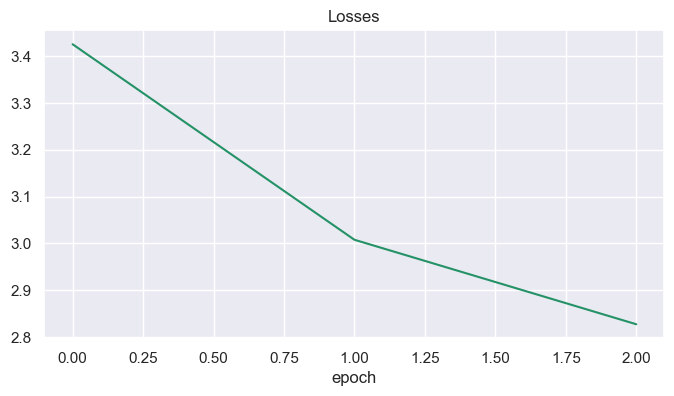

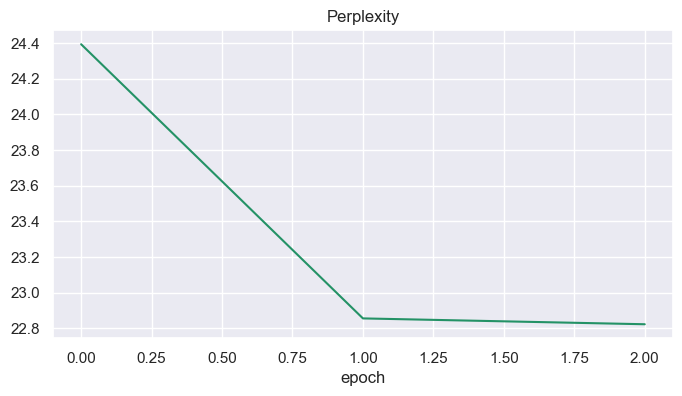

Для 3 эпох:
- Наименьший loss: 2.82712459564209
- Наименьшая перплексия: 22.82334328664316
Wall time: 10min 32s


In [188]:
%%time
rus_model.to(device)
rus_losses, rus_perplexites = train_model(rus_model, rus_optim, rus_criterion, epochs=3)

print(f"Наименьший loss: {min(rus_losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(rus_losses)), rus_losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(rus_perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(rus_perplexites)), rus_perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

print_score(rus_losses, rus_perplexites)

# 2 эпохи
# Наименьший loss: 3.007700204849243
# Наименьшая перплексия: 17.123374662799346

# +2 эпохи
# Наименьший loss: 2.7024662494659424
# Наименьшая перплексия: 14.220132598696285

# +10 эпох

In [189]:
test_word = " ".join([morph.parse(w)[0].normal_form for w in 'на собрании будет объявлен'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

test_word = " ".join([morph.parse(w)[0].normal_form for w in 'по информации от'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

test_word = " ".join([morph.parse(w)[0].normal_form for w in 'гонка вооружения'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

in: на собрание быть объявить
out: на собрание быть объявить что в год в россия быть праздновать летие победа в великий отечественный война

in: по информация от
out: по информация от он получить травма скончаться на место

in: гонка вооружение
out: гонка вооружение в россия начаться в год



'гонка вооружение в россия начаться в год'

In [177]:
test_word = " ".join([morph.parse(w)[0].normal_form for w in 'на собрании будет объявлен'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

test_word = " ".join([morph.parse(w)[0].normal_form for w in 'по информации от'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

test_word = " ".join([morph.parse(w)[0].normal_form for w in 'гонка вооружения'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

in: на собрание быть объявить
out: на собрание быть объявить что в год быть принять решение о проведение собрание митинг

in: по информация от
out: по информация от он получить травма скончаться на место происшествие

in: гонка вооружение
out: гонка вооружение в россия быть подписать президент сша рональд рейган



'гонка вооружение в россия быть подписать президент сша рональд рейган'

In [180]:
test_word = " ".join([morph.parse(w)[0].normal_form for w in 'на собрании будет объявлен'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

test_word = " ".join([morph.parse(w)[0].normal_form for w in 'по информации от'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

test_word = " ".join([morph.parse(w)[0].normal_form for w in 'гонка вооружения'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

in: на собрание быть объявить
out: на собрание быть объявить что в год в россия быть <unk> с <unk> <unk>

in: по информация от
out: по информация от минсельхоз россия в год в год быть объявить в млн

in: гонка вооружение
out: гонка вооружение в россия начаться в год



'гонка вооружение в россия начаться в год'

  0%|          | 0/10 [00:00<?, ?it/s]

0


  0%|          | 0/2364 [00:00<?, ?it/s]

1


  0%|          | 0/2364 [00:00<?, ?it/s]

2


  0%|          | 0/2364 [00:00<?, ?it/s]

3


  0%|          | 0/2364 [00:00<?, ?it/s]

4


  0%|          | 0/2364 [00:00<?, ?it/s]

5


  0%|          | 0/2364 [00:00<?, ?it/s]

6


  0%|          | 0/2364 [00:00<?, ?it/s]

7


  0%|          | 0/2364 [00:00<?, ?it/s]

8


  0%|          | 0/2364 [00:00<?, ?it/s]

9


  0%|          | 0/2364 [00:00<?, ?it/s]

Наименьший loss: 2.0781967639923096
Наименьшая перплексия: 10.404614682449218


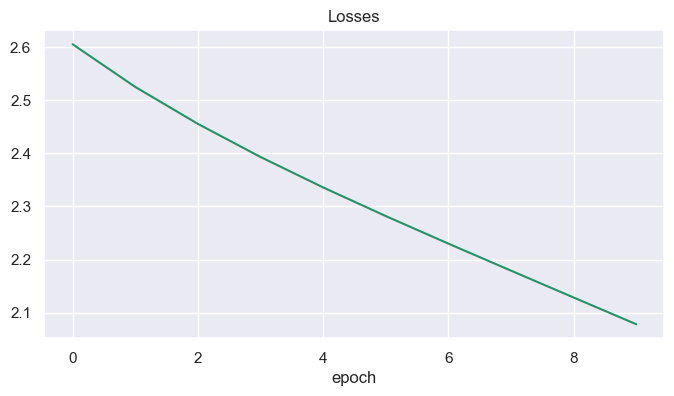

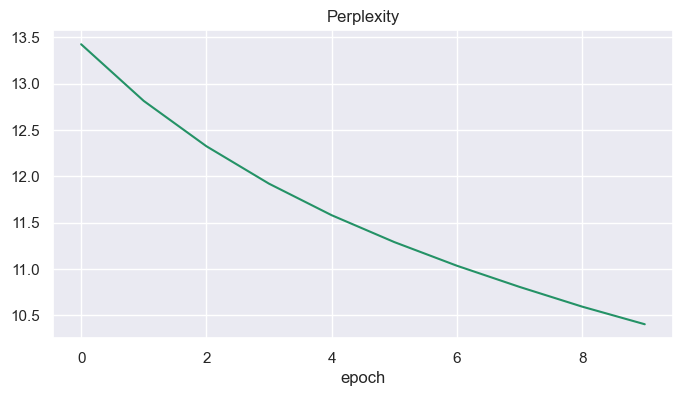

Для 10 эпох:
- Наименьший loss: 2.0781967639923096
- Наименьшая перплексия: 10.404614682449218
Wall time: 39min 49s


In [181]:
%%time
rus_model.to(device)
rus_losses, rus_perplexites = train_model(rus_model, rus_optim, rus_criterion, epochs=10)

print(f"Наименьший loss: {min(rus_losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(rus_losses)), rus_losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(rus_perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(rus_perplexites)), rus_perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

print_score(rus_losses, rus_perplexites)

# 2 эпохи
# Наименьший loss: 3.007700204849243
# Наименьшая перплексия: 17.123374662799346

# +2 эпохи
# Наименьший loss: 2.7024662494659424
# Наименьшая перплексия: 14.220132598696285

# +10 эпох

In [182]:
test_word = " ".join([morph.parse(w)[0].normal_form for w in 'на собрании будет объявлен'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

test_word = " ".join([morph.parse(w)[0].normal_form for w in 'по информации от'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

test_word = " ".join([morph.parse(w)[0].normal_form for w in 'гонка вооружения'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

in: на собрание быть объявить
out: на собрание быть объявить что в день трагедия обман заманить малолетний жертва в жилище

in: по информация от
out: по информация от получить травма он скончаться на место

in: гонка вооружение
out: гонка вооружение в россия начаться с июль год



'гонка вооружение в россия начаться с июль год'

  0%|          | 0/10 [00:00<?, ?it/s]

0


  0%|          | 0/2364 [00:00<?, ?it/s]

1


  0%|          | 0/2364 [00:00<?, ?it/s]

2


  0%|          | 0/2364 [00:00<?, ?it/s]

3


  0%|          | 0/2364 [00:00<?, ?it/s]

4


  0%|          | 0/2364 [00:00<?, ?it/s]

5


  0%|          | 0/2364 [00:00<?, ?it/s]

6


  0%|          | 0/2364 [00:00<?, ?it/s]

7


  0%|          | 0/2364 [00:00<?, ?it/s]

8


  0%|          | 0/2364 [00:00<?, ?it/s]

9


  0%|          | 0/2364 [00:00<?, ?it/s]

Наименьший loss: 1.6621153354644775
Наименьшая перплексия: 9.320017415551275


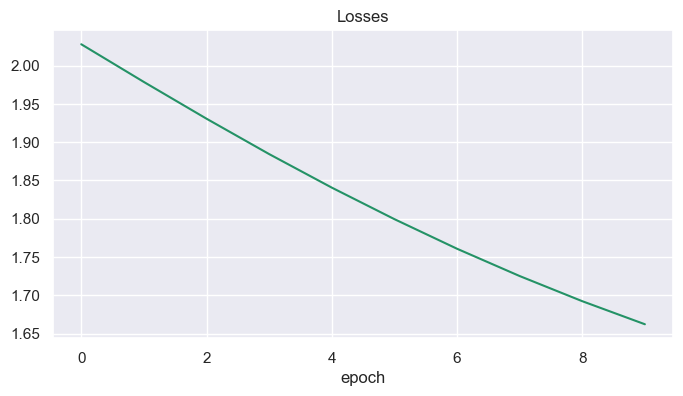

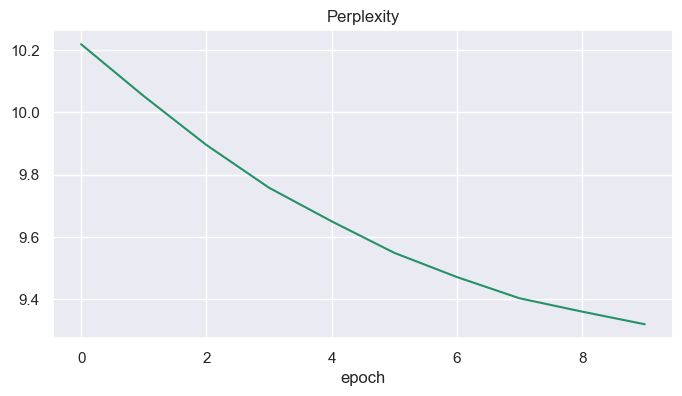

Для 10 эпох:
- Наименьший loss: 1.6621153354644775
- Наименьшая перплексия: 9.320017415551275
Wall time: 39min 43s


In [183]:
%%time
rus_model.to(device)
rus_losses, rus_perplexites = train_model(rus_model, rus_optim, rus_criterion, epochs=10)

print(f"Наименьший loss: {min(rus_losses)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(rus_losses)), rus_losses)
plt.title('Losses')
plt.xlabel("epoch")

print(f"Наименьшая перплексия: {min(rus_perplexites)}")
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(rus_perplexites)), rus_perplexites)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

print_score(rus_losses, rus_perplexites)

# 2 эпохи
# Наименьший loss: 3.007700204849243
# Наименьшая перплексия: 17.123374662799346

# +2 эпохи
# Наименьший loss: 2.7024662494659424
# Наименьшая перплексия: 14.220132598696285

# +20 эпох

In [184]:
test_word = " ".join([morph.parse(w)[0].normal_form for w in 'на собрании будет объявлен'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

test_word = " ".join([morph.parse(w)[0].normal_form for w in 'по информации от'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

test_word = " ".join([morph.parse(w)[0].normal_form for w in 'гонка вооружения'.split(" ")])
generate_sequence(rus_model, starting_seq=test_word)

in: на собрание быть объявить
out: на собрание быть объявить что запуск газопровод турецкий поток не влиять на желание игрок

in: по информация от
out: по информация от телеканал рен тв москвич оскорбить лёгкий

in: гонка вооружение
out: гонка вооружение считать что армия сша мочь наносить удар по иранский сила сша



'гонка вооружение считать что армия сша мочь наносить удар по иранский сила сша'

### Пример реализации на русском языке

Т.к. в руссском много разнообразных окончаний, склонений, падежей и прочее, общий словарь всех словоформ составляет очень большой размер, поэтмоу для обучения на русском языке использовалась лемматизация (приведение слов к нормальной форме). Соответсвтенно ответ модели также идет в словах в нормальной форме

|Кол-во эпох|Loss|Перплексия|Текст 1<br> "на собрание быть объявить"|Текст 2 <br>"по информация от"|Текст 3 <br>"гонка вооружение"|
|---|---|---|---|---|---|
|2|3.00|17.12|на собрание быть объявить что в год быть принять решение о проведение собрание митинг|по информация от он получить травма скончаться на место происшествие|гонка вооружение в россия быть подписать президент сша рональд рейган|
|4|2.70|14.22|на собрание быть объявить что в год в россия быть <unk> с <unk> <unk>|по информация от минсельхоз россия в год в год быть объявить в млн|гонка вооружение в россия начаться в год|
|14|2.07|10.40|на собрание быть объявить что в день трагедия обман заманить малолетний жертва в жилище|по информация от получить травма он скончаться на место|гонка вооружение в россия начаться с июль год|
|24|1.66|9.32|на собрание быть объявить что запуск газопровод турецкий поток не влиять на желание игрок|по информация от телеканал рен тв москвич оскорбить лёгкий|гонка вооружение считать что армия сша мочь наносить удар по иранский сила сша

    
Обучение шло порционно 2 эпохи + 2эп. + 10эп + 10эп.
График лосса и перплексии:
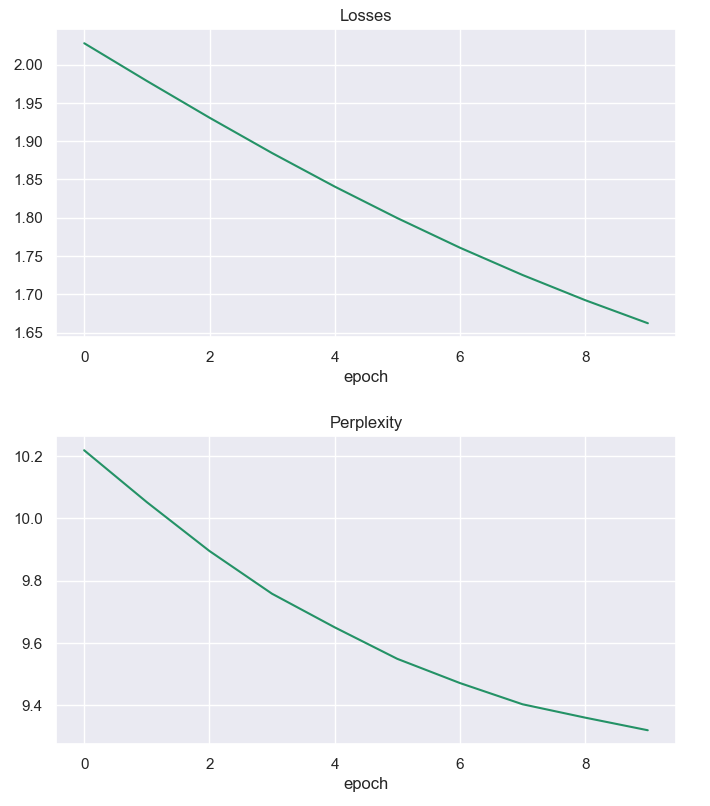

Переобучение не началось можно увеличивать кол-во эпох. Усложенние модели ведет к полдолжительному времени обучения.
    